# GPS Tracking Data Analysis on the Northern Motorway

Zhen Cheng 13040788

Yonghui Rao 16093645

# Introduction

## Background

The Auckland Northern Motorway (known locally as the Northern Motorway, and historically as the Auckland–Waiwera Motorway) in the Auckland Region of New Zealand links central Auckland City and Puhoi in the former Rodney District via the Hibiscus Coast and North Shore. It is part of State Highway 1.

It is 38 kilometres (24 mi) in length, with 15 junctions. Until the end of the 1980s, it was largely associated with the Auckland Harbour Bridge as a connection between central Auckland and the North Shore, but since 1994 it has been extended to Puhoi to become the primary route between the Auckland urban area, the Hibiscus Coast satellite towns, the northern Rodney district, and Northland. Between the 1959 opening of the motorway and 1984, tolls were collected on the Auckland Harbour Bridge, and since 2009 tolls have been collected on the Northern Gateway Toll Road, the northernmost section of the motorway, bypassing the Hibiscus Coast.

The Northern Motorway sees heavy traffic: the section between Esmonde Road and Cook Street has an annual average daily traffic (AADT) count of over 100,000 vehicles per day, with around 155,000 vehicles per day crossing the Harbour Bridge.
                                     
                                                referred from https://en.wikipedia.org/wiki/Auckland_Northern_Motorway

## Purpose

This notebook aims to analyse GPS tracking data of vehicles on Northern Motorway. The speed, direction, location and time are analysed respectively. We want to build predictive models and find out the relationships between them. We will also try to build cluster model to distinguish buses and trucks.

## Research Questions

1. On which day in a week the traffic is buiest and on which day the traffic is smooth
2. In which period the traffic is busiest on weekday?
3. Is there a relationship between speed and hour of weekday?
4. Is there a relationship between speed and directiton?
5. Which direction means a faster speed, north or south?
6. Is it reliable to predict direction(South or North) based on speed and time?
7. Is it reliable to distinguish buses and trucks based on mean location of events?
8. Is it reliable to distinguish week day based on speed and direction(angle)?

## Data Sources

Data is collected from stream.massey.ac.nz

## Other Information

This notebook may take a few munutes to finish running all cells, because there are 1600 files in the zip and lots of  rows in dataframe.

## Main Findings

Based on our analysis, we found that Wednesday is the busiest day in a week. During 19:00 to 21:00 the traffic is busier on weekday. The speed and direction has no strong relationship. Driving to north usually means a faster speed. We can predict direction based on our model but can not predict week day based on speed and direction. Details will be presented in following sections,


# Part 1 - Data Analysis

In this part, we will firstly analyse Machine Data and Northern Motorway Road Segments Data seperatly, then build prediction models and verify the fitness.

In [138]:
import requests                 
from bs4 import BeautifulSoup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from time import sleep


import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime as dt

import statsmodels.formula.api as smf
import mpld3
from sklearn import preprocessing
import zipfile as zf


In [139]:
import patsy

In [140]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import math 
from sklearn import neighbors

%matplotlib inline

In [141]:
pd.options.display.max_columns = 50
from pylab import rcParams

sns.set(style="ticks")
#sns.set_style("whitegrid")
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 10,8
rcParams['font.size'] = 20

In [142]:
rcParams['axes.labelsize'] = 'medium'
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15


## Machine Data

THe Machine data has been compressed as a zip file, read it and store it to a dataFrame.

### Prepare Data

In [143]:
machine_data = zf.ZipFile('Machine data.zip') 
print len(machine_data.namelist())
first_file = machine_data.namelist()[1]
print first_file

1601
21564-2016-03-16 162552.csv


The zip file contains 1600 except '/', show the data format

In [144]:
df_machine_data_1 = pd.io.parsers.read_csv(
    machine_data.open(first_file),
    )
df_machine_data_1.head(5)

id;"event_timestamp";"course_over_ground";"machine_id";"vehicle_weight_type";"speed_gps_kph";"latitude";"longitude"
0  14664310488;2015-11-16 08:22:18;153;21564;"HEA...                                                                 
1  14660741605;2015-11-16 03:56:59;142;21564;"HEA...                                                                 
2  14663873754;2015-11-16 07:29:33;324;21564;"HEA...                                                                 
3  14660725082;2015-11-16 03:55:48;153;21564;"HEA...                                                                 
4  14664252097;2015-11-16 08:15:11;52;21564;"HEAV...

Each csv file contains one column, combine all of them

In [145]:
# this cell may take some time to append 1600 files.
df_machine_data = pd.DataFrame()
for file in  machine_data.namelist():
    if file != '/':
       # print file
        machine_data_file = pd.io.parsers.read_csv(
        machine_data.open(file),
        )
        #print machine_data_file.head(5)
        df_machine_data = df_machine_data.append(machine_data_file)
print df_machine_data.head(5)

  id;"event_timestamp";"course_over_ground";"machine_id";"vehicle_weight_type";"speed_gps_kph";"latitude";"longitude"
0  14664310488;2015-11-16 08:22:18;153;21564;"HEA...                                                                 
1  14660741605;2015-11-16 03:56:59;142;21564;"HEA...                                                                 
2  14663873754;2015-11-16 07:29:33;324;21564;"HEA...                                                                 
3  14660725082;2015-11-16 03:55:48;153;21564;"HEA...                                                                 
4  14664252097;2015-11-16 08:15:11;52;21564;"HEAV...                                                                 


In [146]:
ori_col = df_machine_data.columns[0]
column = df_machine_data.columns[0]
new_cols = column.replace('"', '').split(';');
print new_cols

['id', 'event_timestamp', 'course_over_ground', 'machine_id', 'vehicle_weight_type', 'speed_gps_kph', 'latitude', 'longitude']


There's only one column, need to split it to multiple columns.

In [147]:
# Only keep new cols
df_machine_data[new_cols] = df_machine_data[ori_col].str.split(';', expand= True)
df_machine_data = df_machine_data[new_cols]
df_machine_data.head(5)

id      event_timestamp course_over_ground machine_id  \
0  14664310488  2015-11-16 08:22:18                153      21564   
1  14660741605  2015-11-16 03:56:59                142      21564   
2  14663873754  2015-11-16 07:29:33                324      21564   
3  14660725082  2015-11-16 03:55:48                153      21564   
4  14664252097  2015-11-16 08:15:11                 52      21564   

  vehicle_weight_type speed_gps_kph    latitude   longitude  
0             "HEAVY"            77  -36.776549  174.745603  
1             "HEAVY"            88   -36.79681  174.759796  
2             "HEAVY"            81  -36.751055  174.726128  
3             "HEAVY"            91   -36.78271  174.749418  
4             "HEAVY"             0   -36.71874  174.712123

Now we've got the formated dataframe 

### Analyse Event Number by Day and Hour

In [148]:
# convert type of 'timestamp' tp datetime from string
df_machine_data['event_timestamp']=df_machine_data['event_timestamp'].apply(pd.to_datetime)


In [149]:
df_machine_data['what_day']=df_machine_data['event_timestamp'].dt.dayofweek
# 0 is Monday and 6 is Sunday..
unique_days = df_machine_data.what_day.unique()

In [150]:
day_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday' ,3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_machine_data['what_day'] = df_machine_data.what_day.map(day_mapping)
df_machine_data[df_machine_data.what_day == 'Saturday'].size

0

In [151]:
df_machine_data['vehicle_weight_type'] = df_machine_data.vehicle_weight_type.str.replace('"','')
df_machine_data.head(5)

id     event_timestamp course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                153      21564   
1  14660741605 2015-11-16 03:56:59                142      21564   
2  14663873754 2015-11-16 07:29:33                324      21564   
3  14660725082 2015-11-16 03:55:48                153      21564   
4  14664252097 2015-11-16 08:15:11                 52      21564   

  vehicle_weight_type speed_gps_kph    latitude   longitude what_day  
0               HEAVY            77  -36.776549  174.745603   Monday  
1               HEAVY            88   -36.79681  174.759796   Monday  
2               HEAVY            81  -36.751055  174.726128   Monday  
3               HEAVY            91   -36.78271  174.749418   Monday  
4               HEAVY             0   -36.71874  174.712123   Monday

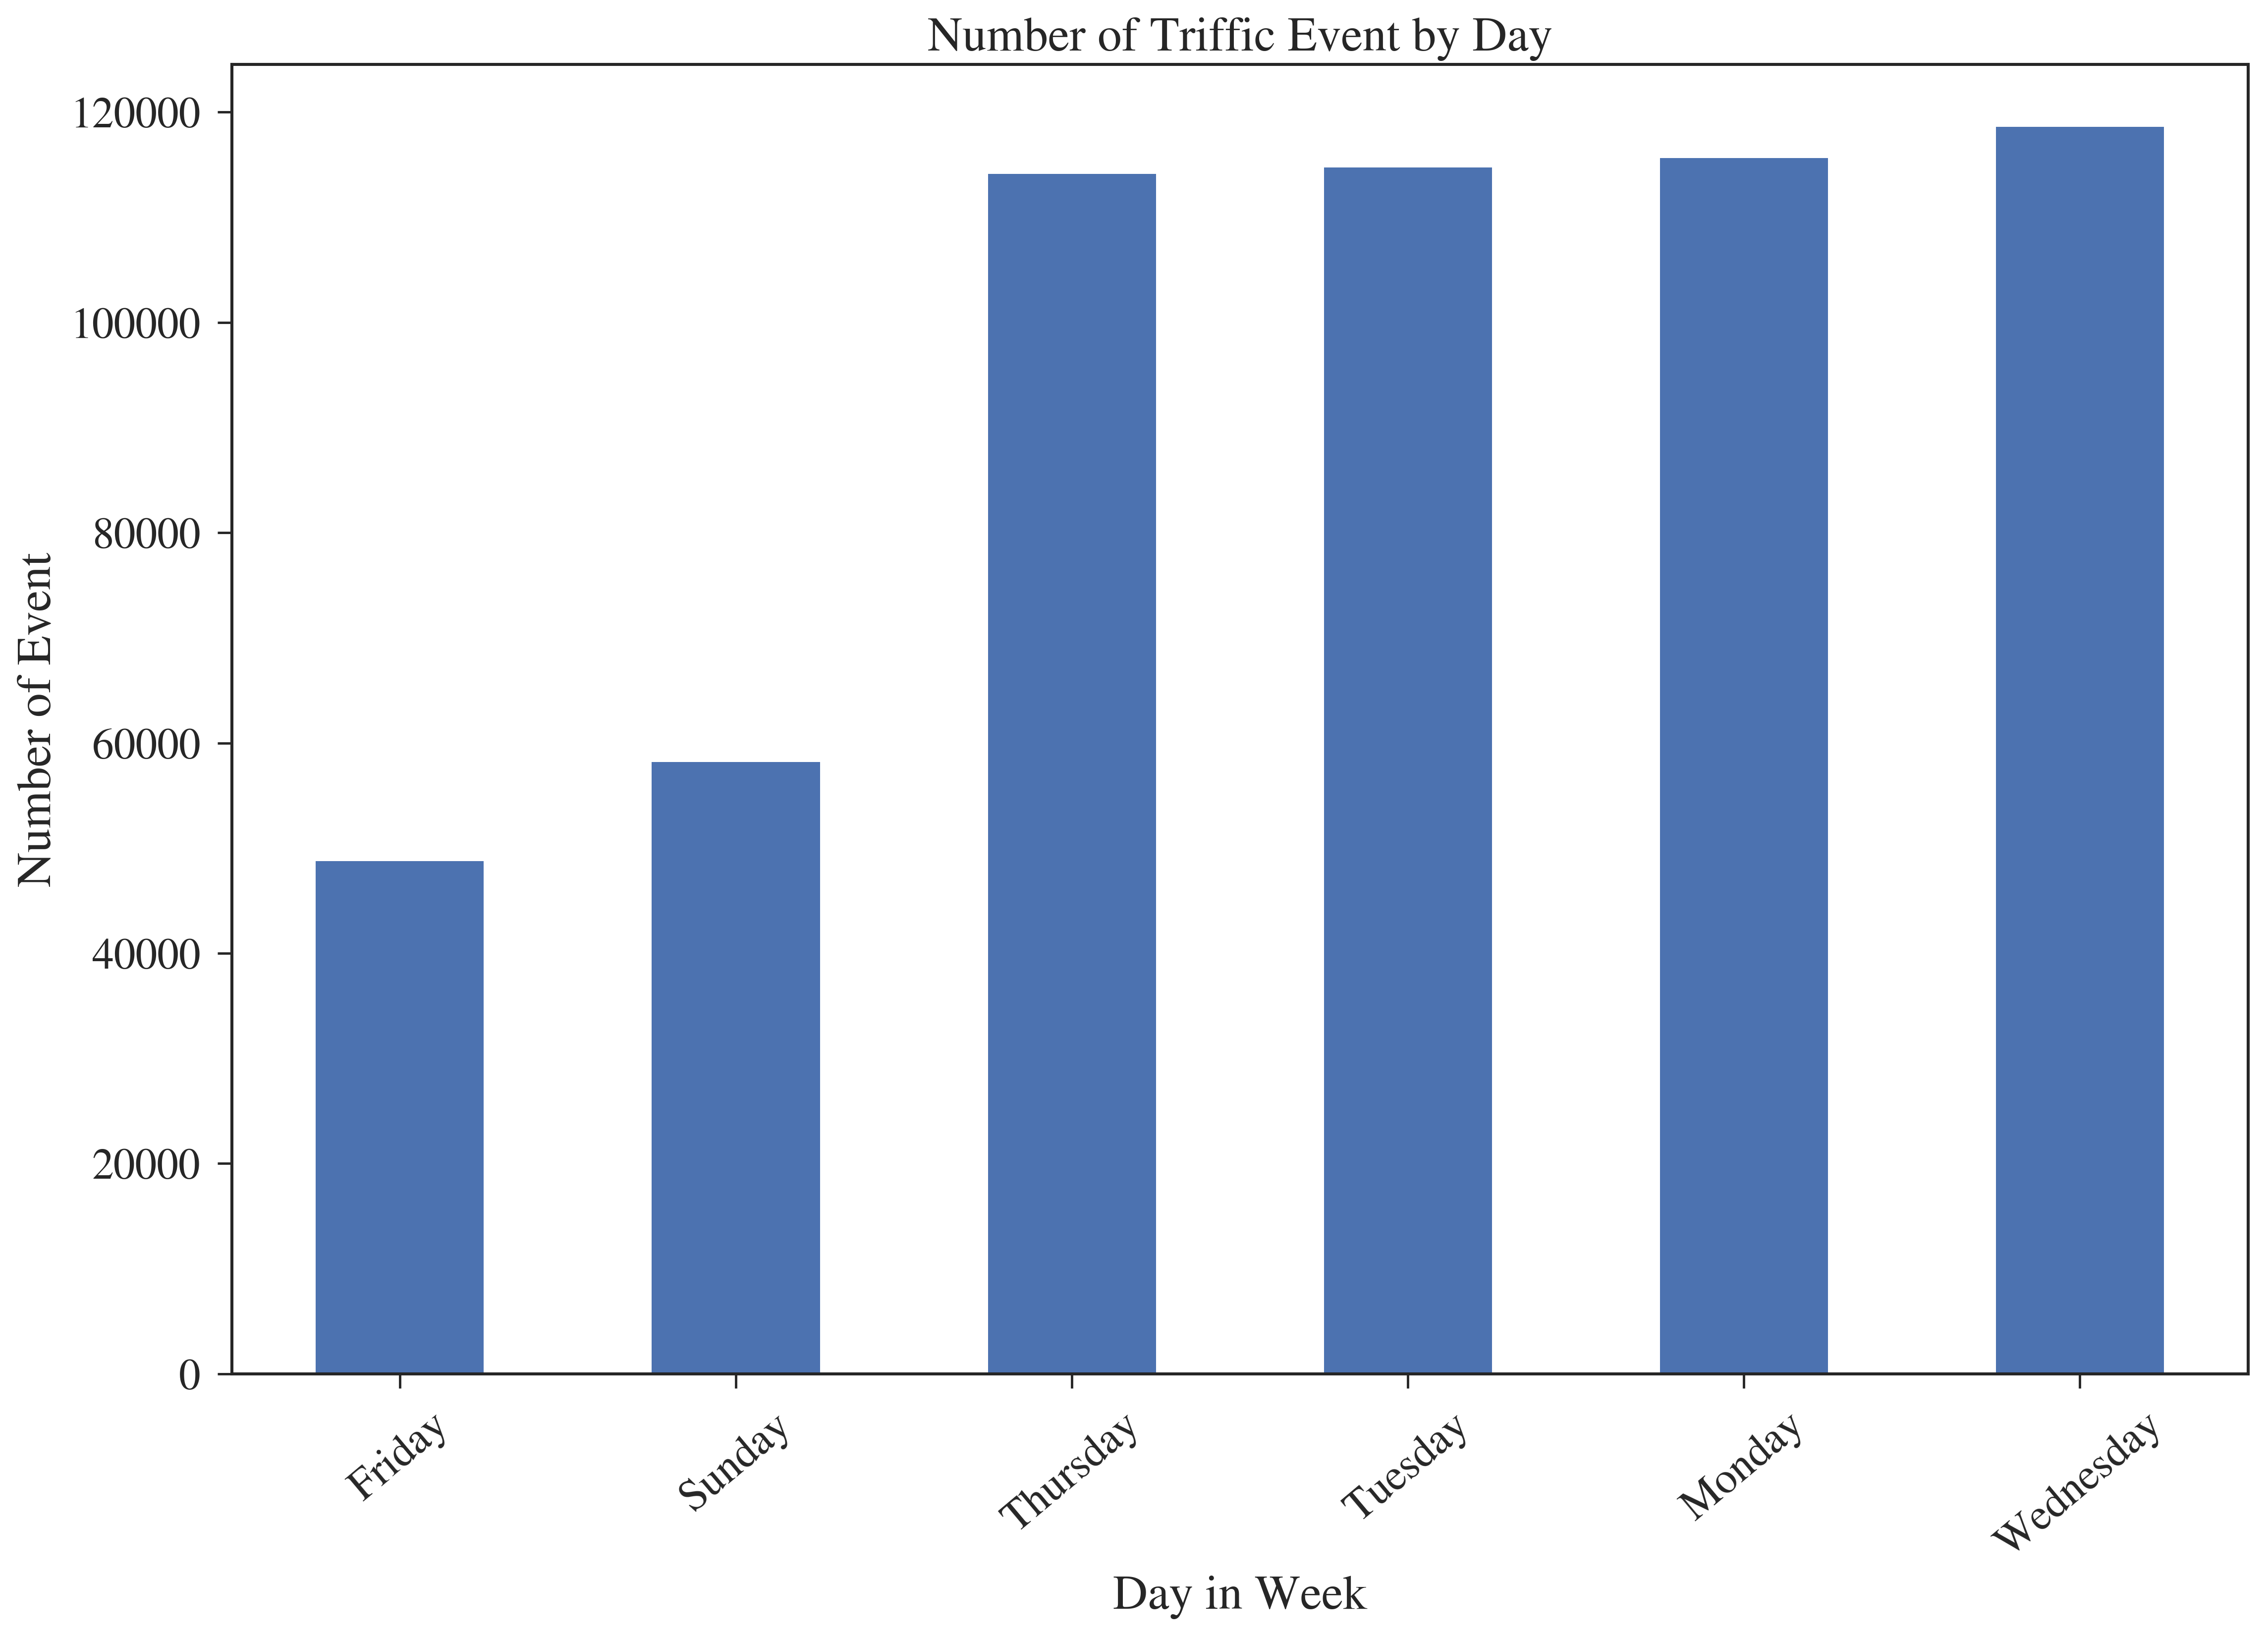

In [152]:
series_day = df_machine_data['what_day'].groupby([df_machine_data["what_day"]]).count()
series_day = series_day.sort_values( ascending=[True])

ax=series_day.plot(kind='bar', figsize=(15, 10), legend=False, fontsize=18, rot=40)
ax.set_xlabel('Day in Week', fontsize=20)
ax.set_ylabel('Number of Event', fontsize=20)
ax.set_title('Number of Triffic Event by Day', fontsize=20) 

From the figure above, we can see that Wednesday is the busiest day in a week.
Now we will compare event count by hour.

In [153]:
df_machine_data['period'] =  df_machine_data['event_timestamp'].apply(lambda x: x.hour)
df_machine_data.head(5)

id     event_timestamp course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                153      21564   
1  14660741605 2015-11-16 03:56:59                142      21564   
2  14663873754 2015-11-16 07:29:33                324      21564   
3  14660725082 2015-11-16 03:55:48                153      21564   
4  14664252097 2015-11-16 08:15:11                 52      21564   

  vehicle_weight_type speed_gps_kph    latitude   longitude what_day  period  
0               HEAVY            77  -36.776549  174.745603   Monday       8  
1               HEAVY            88   -36.79681  174.759796   Monday       3  
2               HEAVY            81  -36.751055  174.726128   Monday       7  
3               HEAVY            91   -36.78271  174.749418   Monday       3  
4               HEAVY             0   -36.71874  174.712123   Monday       8

In [154]:

series_period = df_machine_data['period'].groupby([df_machine_data["period"]]).count()

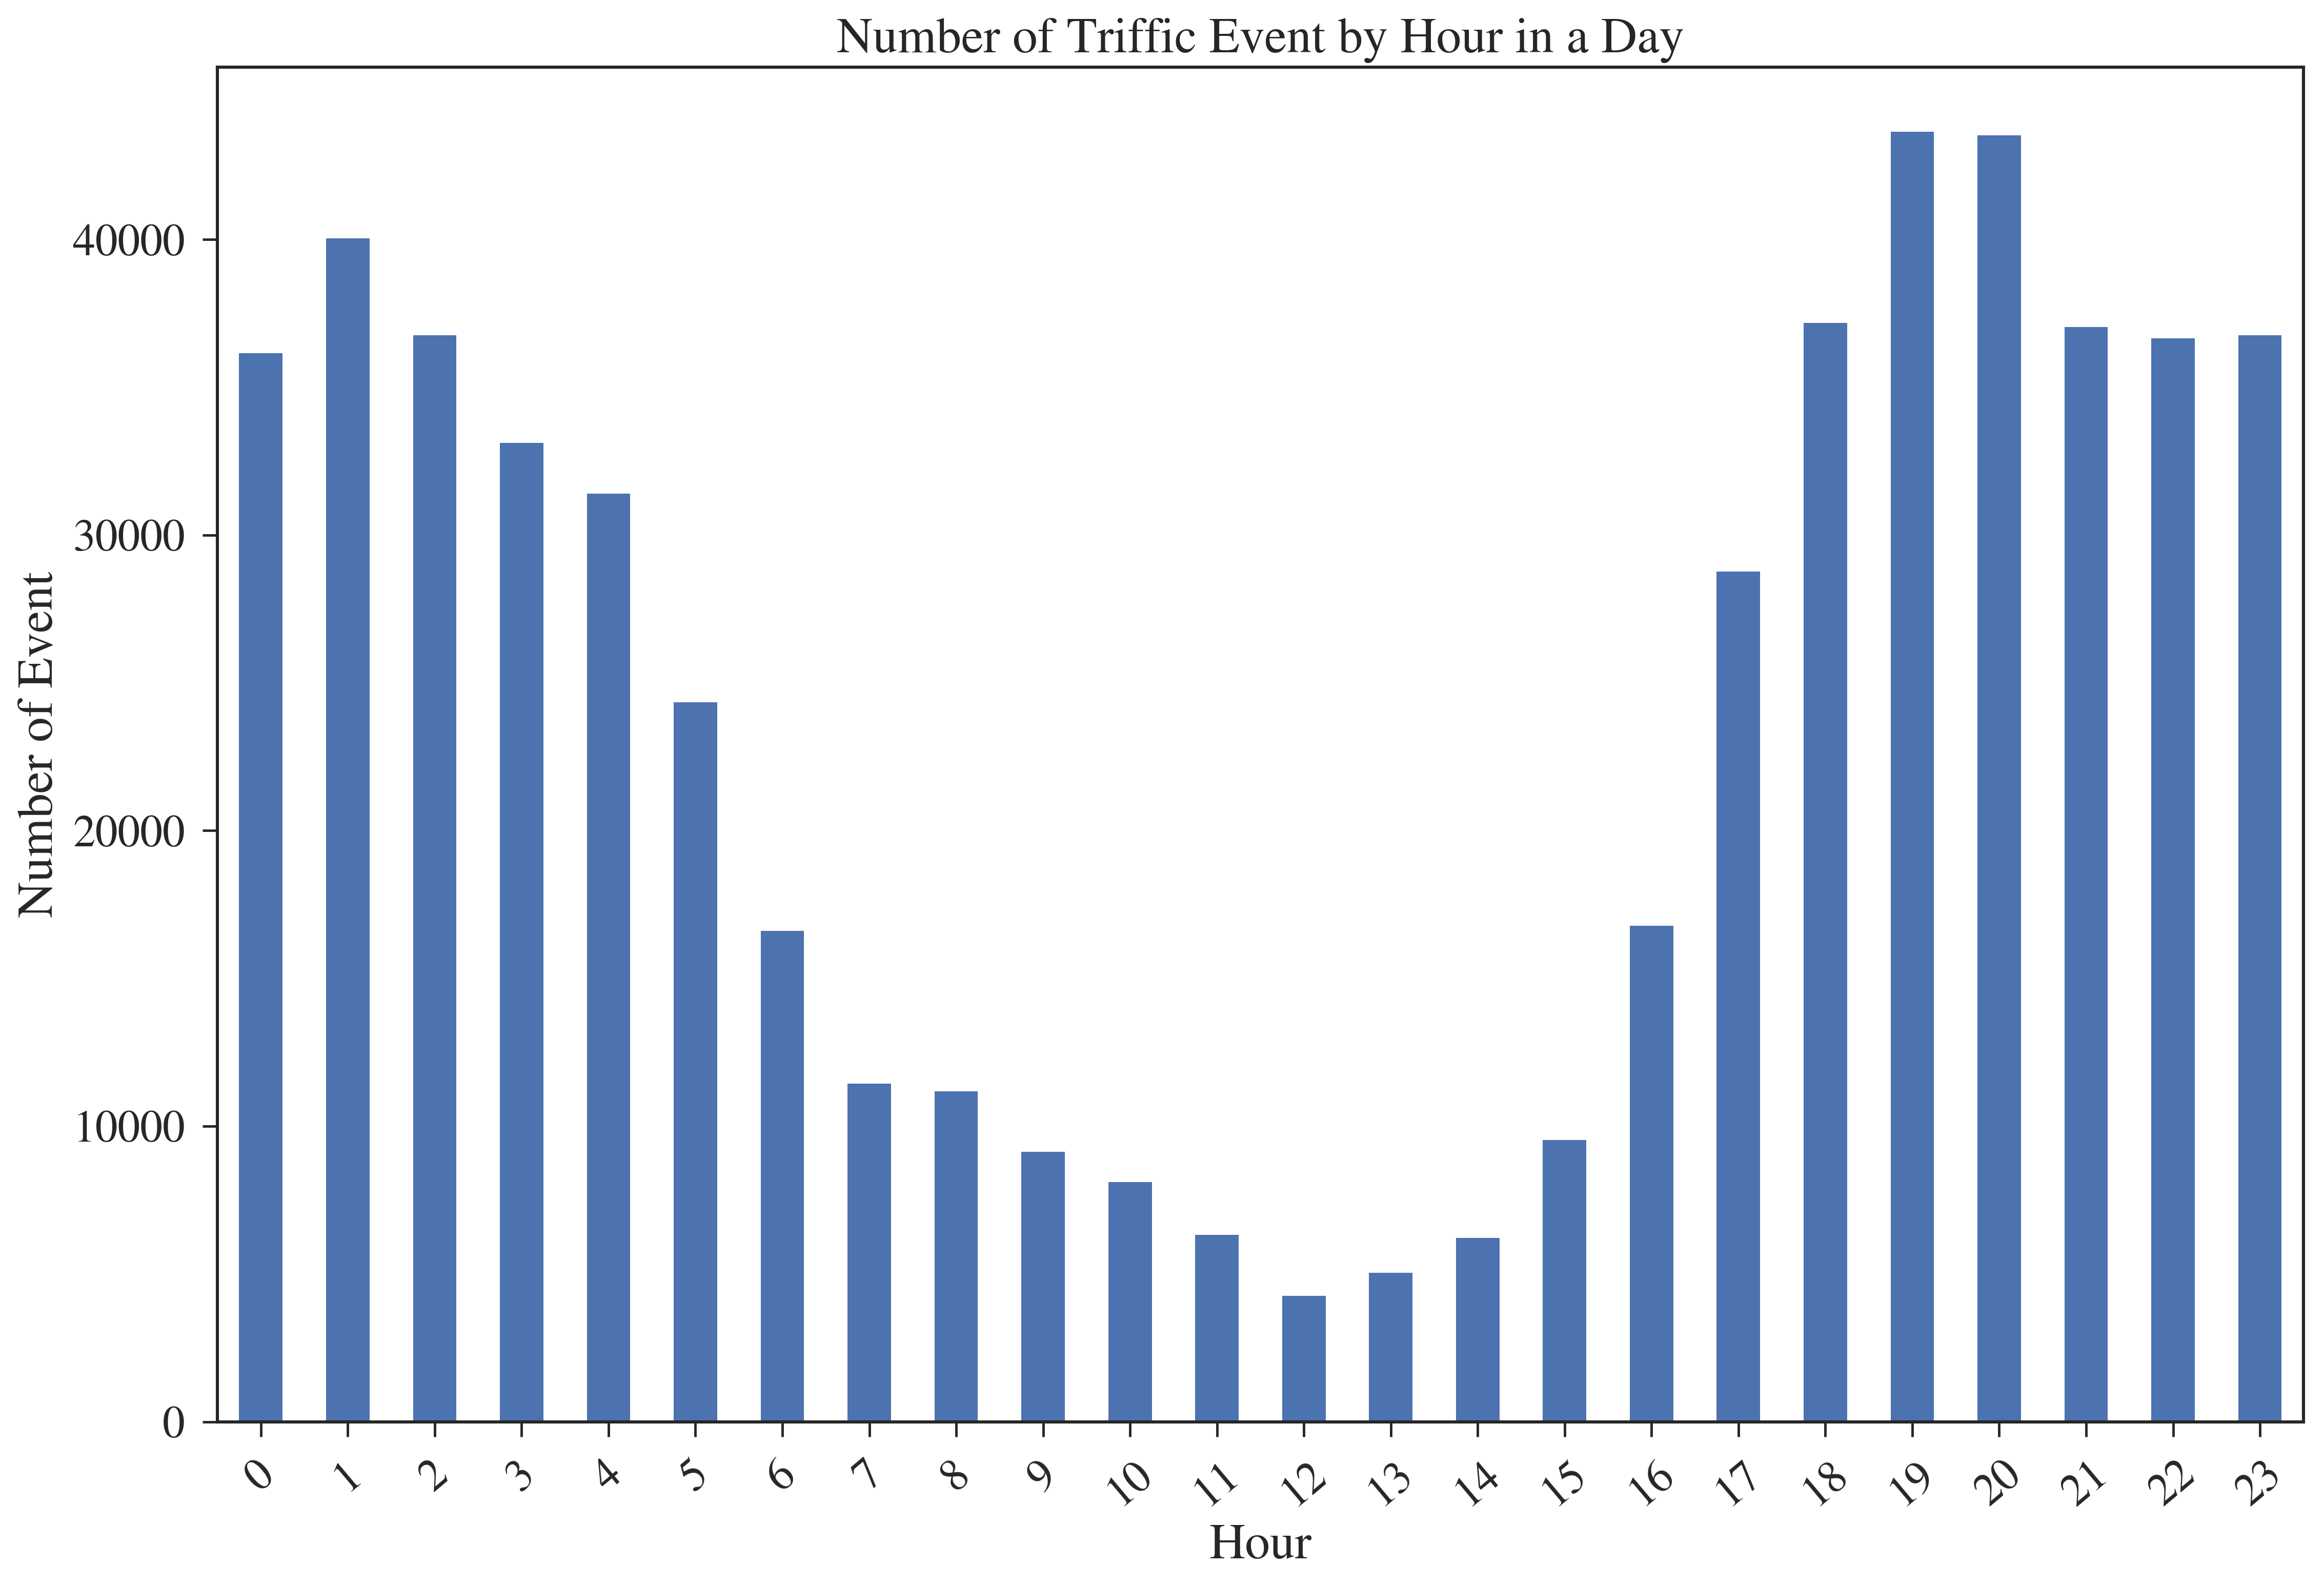

In [155]:

ax=series_period.plot(kind='bar', figsize=(15, 10), legend=False, fontsize=18, rot=40)
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Number of Event', fontsize=20)
ax.set_title('Number of Triffic Event by Hour in a Day', fontsize=20) 


We are expecting to see more events in day time rather than night, however it doesn't happen, the reason may be the data is not complete, not all events in one day are included.
Based on the fact above, we need to find another way to investigate the traffic status, vehicle's speed would be a good choice.


### Analyse on Speed by Hour

In [156]:
df_machine_data['speed_gps_kph'] = pd.to_numeric(df_machine_data['speed_gps_kph'], errors='coerce')
df_machine_data_weekday =  df_machine_data[df_machine_data.what_day != 'Sunday']
df_machine_data_weekday = df_machine_data_weekday[df_machine_data_weekday.what_day != 'Saturday']

In [157]:

def get_mean(values):
    return values.mean()

grouped_count = df_machine_data_weekday.groupby("period").speed_gps_kph.agg(get_mean)


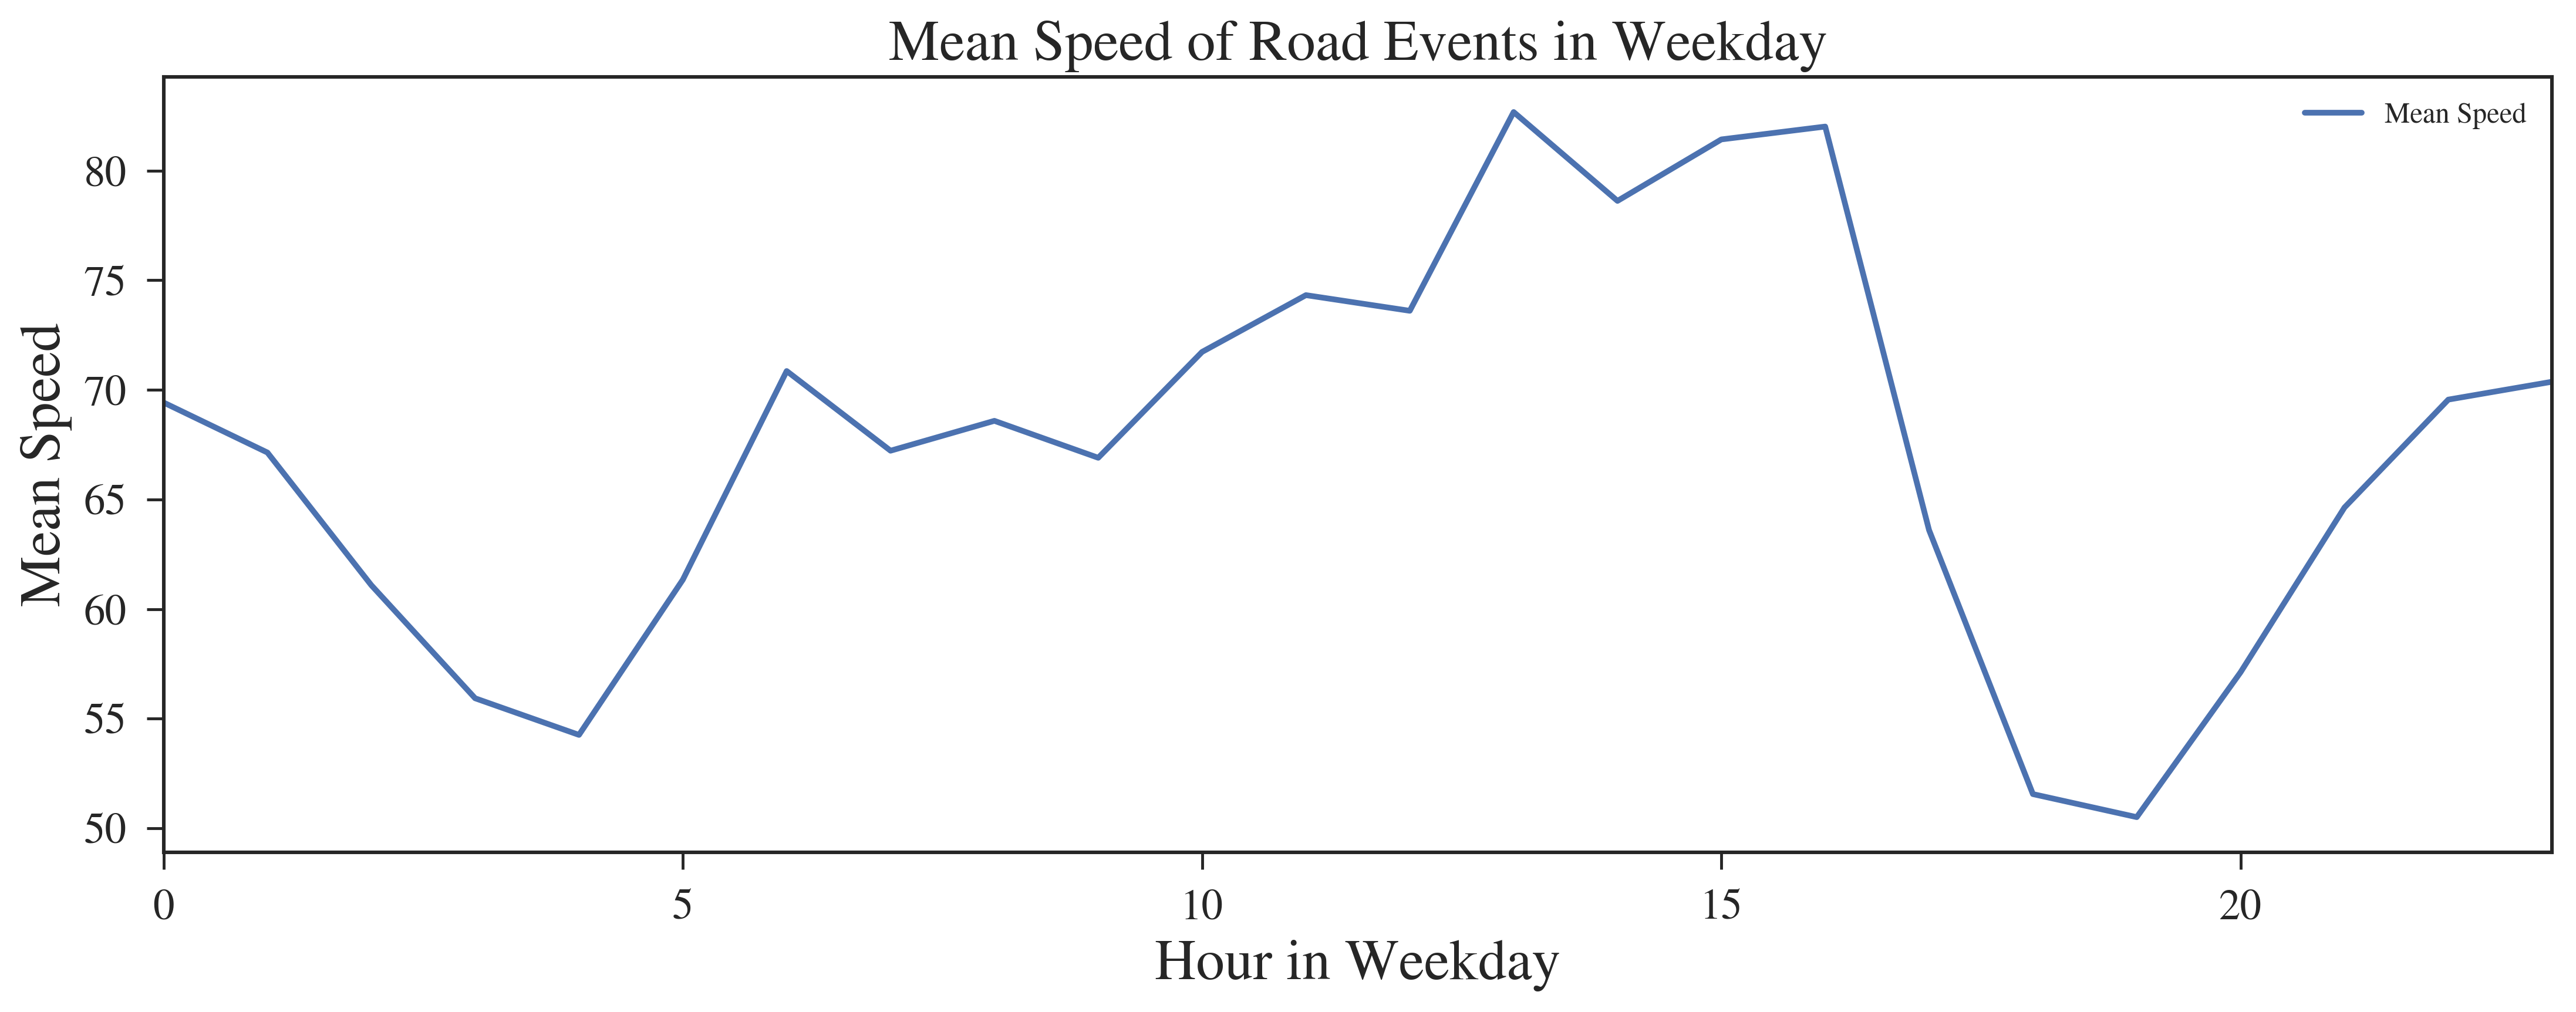

In [158]:

ax = grouped_count.plot(x='Hour in Weekday', y='Mean Speed', figsize=(15,5))
ax.set_xlabel('Hour in Weekday')
ax.set_ylabel('Mean Speed')
ax.set_title('Mean Speed of Road Events in Weekday', fontsize=20)   
ax.legend(["Mean Speed"]);


### Analyse on Speed and Direction

The Northern Motorway Road is in North - South direction, it is very possible that the road is busy towards one direction but smooth on another direction, so it is meaningful to analyse speed regarding to different directions.


In [159]:
def direction_map(angle):
    if angle > 90 and angle < 270:
        return 'South'
    else:
        return 'North'
df_machine_data['course_over_ground'] = pd.to_numeric(df_machine_data['course_over_ground'], errors='coerce')
df_machine_data['direction'] =  df_machine_data['course_over_ground'].apply(lambda x: direction_map(x))
df_machine_data.head(5)
    

id     event_timestamp  course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                 153      21564   
1  14660741605 2015-11-16 03:56:59                 142      21564   
2  14663873754 2015-11-16 07:29:33                 324      21564   
3  14660725082 2015-11-16 03:55:48                 153      21564   
4  14664252097 2015-11-16 08:15:11                  52      21564   

  vehicle_weight_type  speed_gps_kph    latitude   longitude what_day  period  \
0               HEAVY             77  -36.776549  174.745603   Monday       8   
1               HEAVY             88   -36.79681  174.759796   Monday       3   
2               HEAVY             81  -36.751055  174.726128   Monday       7   
3               HEAVY             91   -36.78271  174.749418   Monday       3   
4               HEAVY              0   -36.71874  174.712123   Monday       8   

  direction  
0     South  
1     South  
2     North  
3     South  
4     North

In [160]:
df_machine_data['speed_gps_kph'] = pd.to_numeric(df_machine_data['speed_gps_kph'], errors='coerce')
df_machine_data_weekday =  df_machine_data[df_machine_data.what_day != 'Sunday']
df_machine_data_weekday = df_machine_data_weekday[df_machine_data_weekday.what_day != 'Saturday']
df_machine_data_weekday_S = df_machine_data_weekday[df_machine_data_weekday.direction == 'South']
df_machine_data_weekday_N = df_machine_data_weekday[df_machine_data_weekday.direction == 'North']


In [161]:

def get_mean(values):
    return values.mean()

grouped_count_S = df_machine_data_weekday_S.groupby("period").speed_gps_kph.agg(get_mean)
grouped_count_N = df_machine_data_weekday_N.groupby("period").speed_gps_kph.agg(get_mean)

In [162]:
df_machine_data_weekday.direction.unique()

array(['South', 'North'], dtype=object)

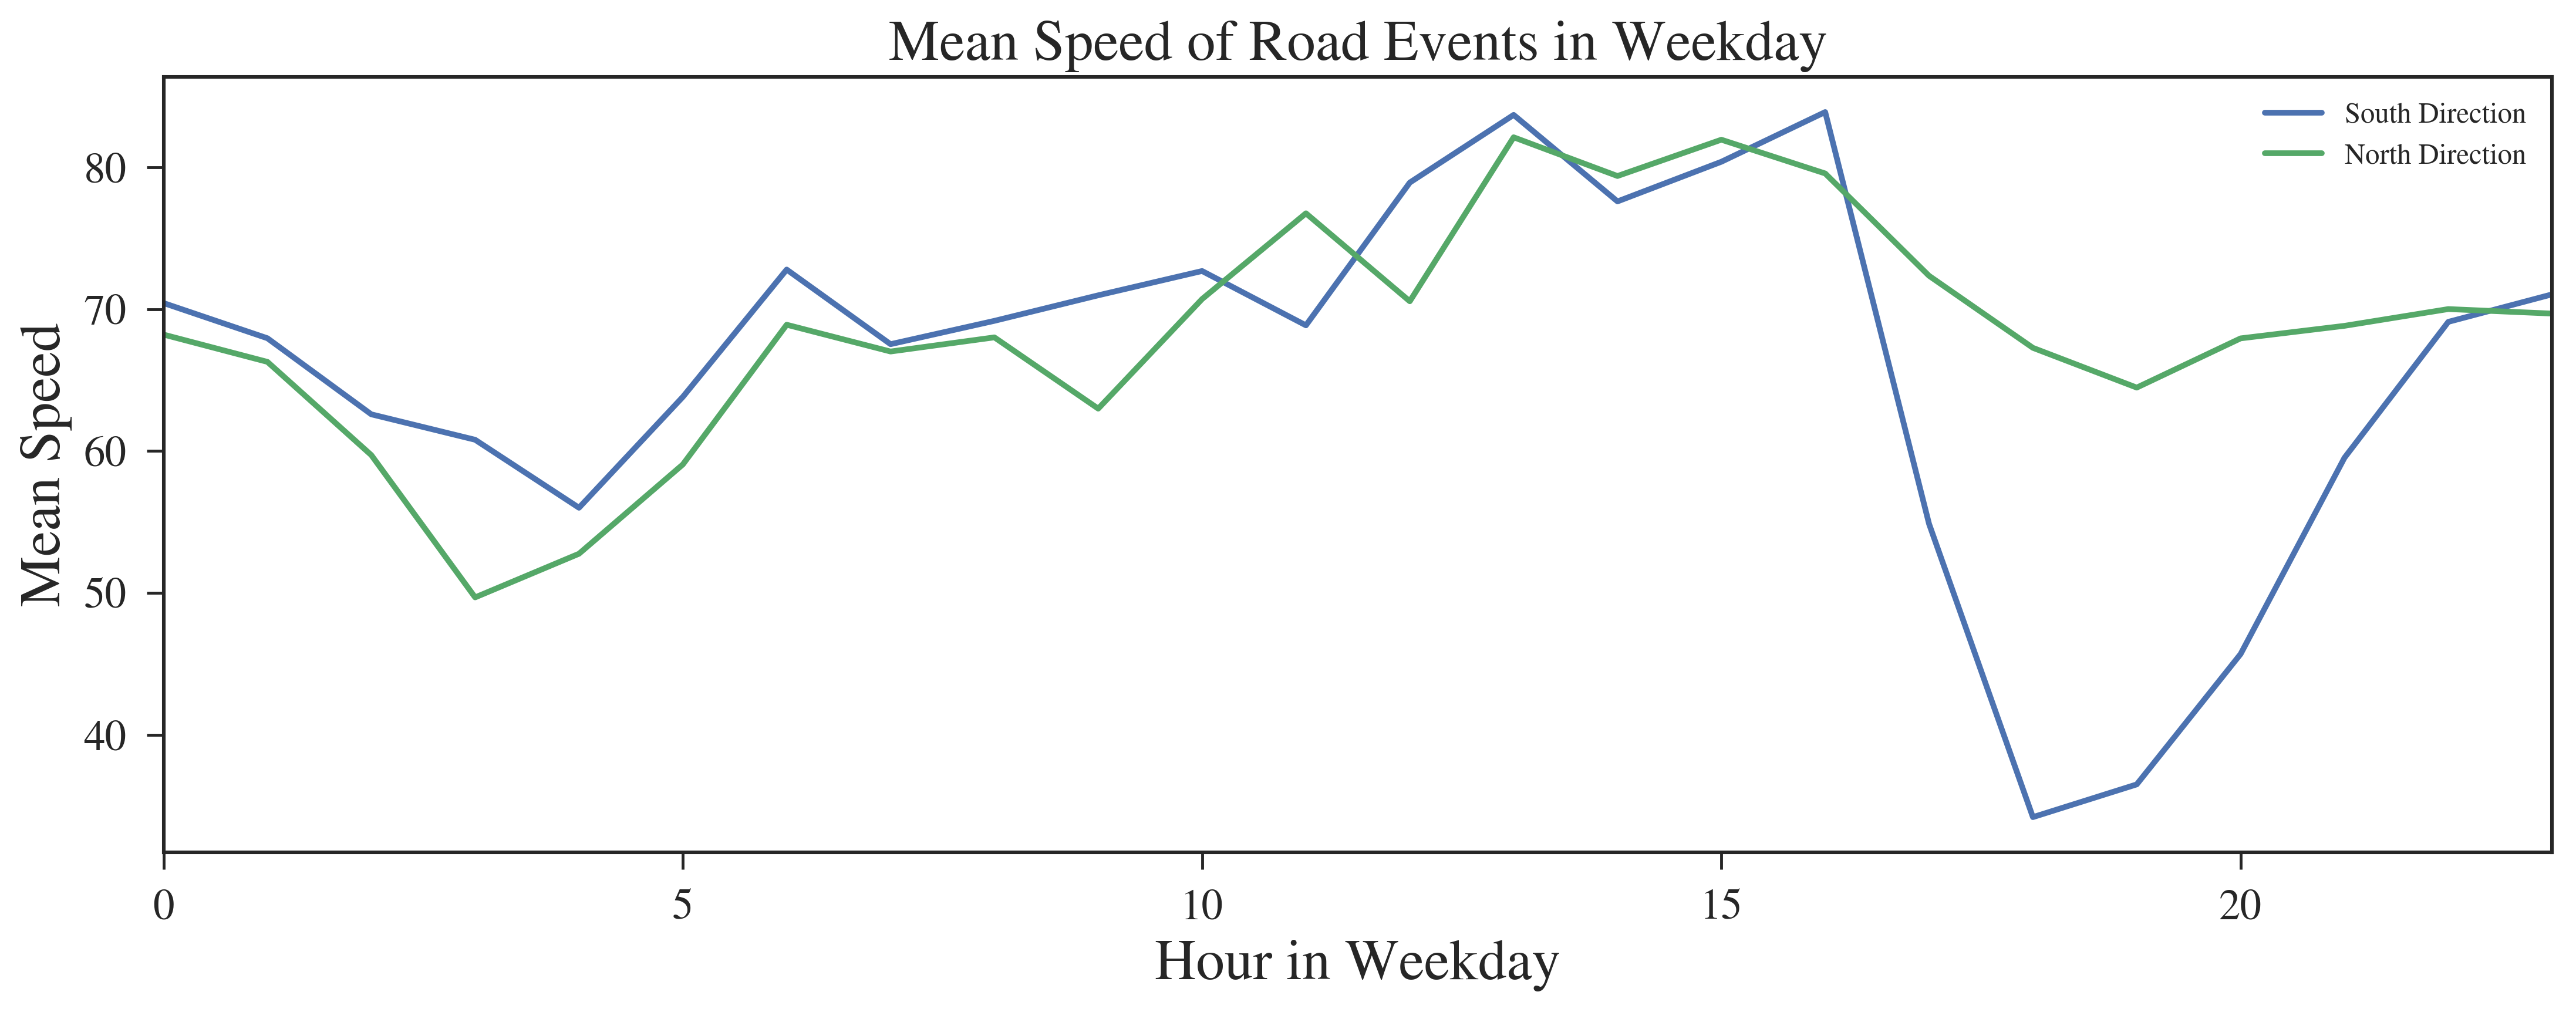

In [163]:
import matplotlib.pyplot as plt

ax=grouped_count_S.plot(x='Hour in Weekday', y='Mean Speed', figsize=(15,5),title='Mean Speed of Road Events in Weekday')
grouped_count_N.plot(x='Hour in Weekday', y='Mean Speed', figsize=(15,5),title='Mean Speed of Road Events in Weekday',ax=ax)

ax.set_xlabel('Hour in Weekday', fontsize=20)
ax.set_ylabel('Mean Speed', fontsize=20)
ax.set_title('Mean Speed of Road Events in Weekday', fontsize=20)   
ax.legend(["South Direction",'North Direction']);

The figure shows that in most time, the speed of different directions do not show a big difference, however, during 17:00 to 23:00, driving to south is much slower than driving to north. 

Similarly, we are trying to analyse mean speed by day regarding to different directions and weight types.

### Analyse on Speed  and Directions by Day

In [164]:
print df_machine_data_weekday.vehicle_weight_type.unique()
df_machine_data_weekday_weight = df_machine_data_weekday[df_machine_data_weekday.vehicle_weight_type != 'NA']
print df_machine_data_weekday_weight.vehicle_weight_type.unique()

['HEAVY' 'LIGHT' 'NA']
['HEAVY' 'LIGHT']


(0, 150)

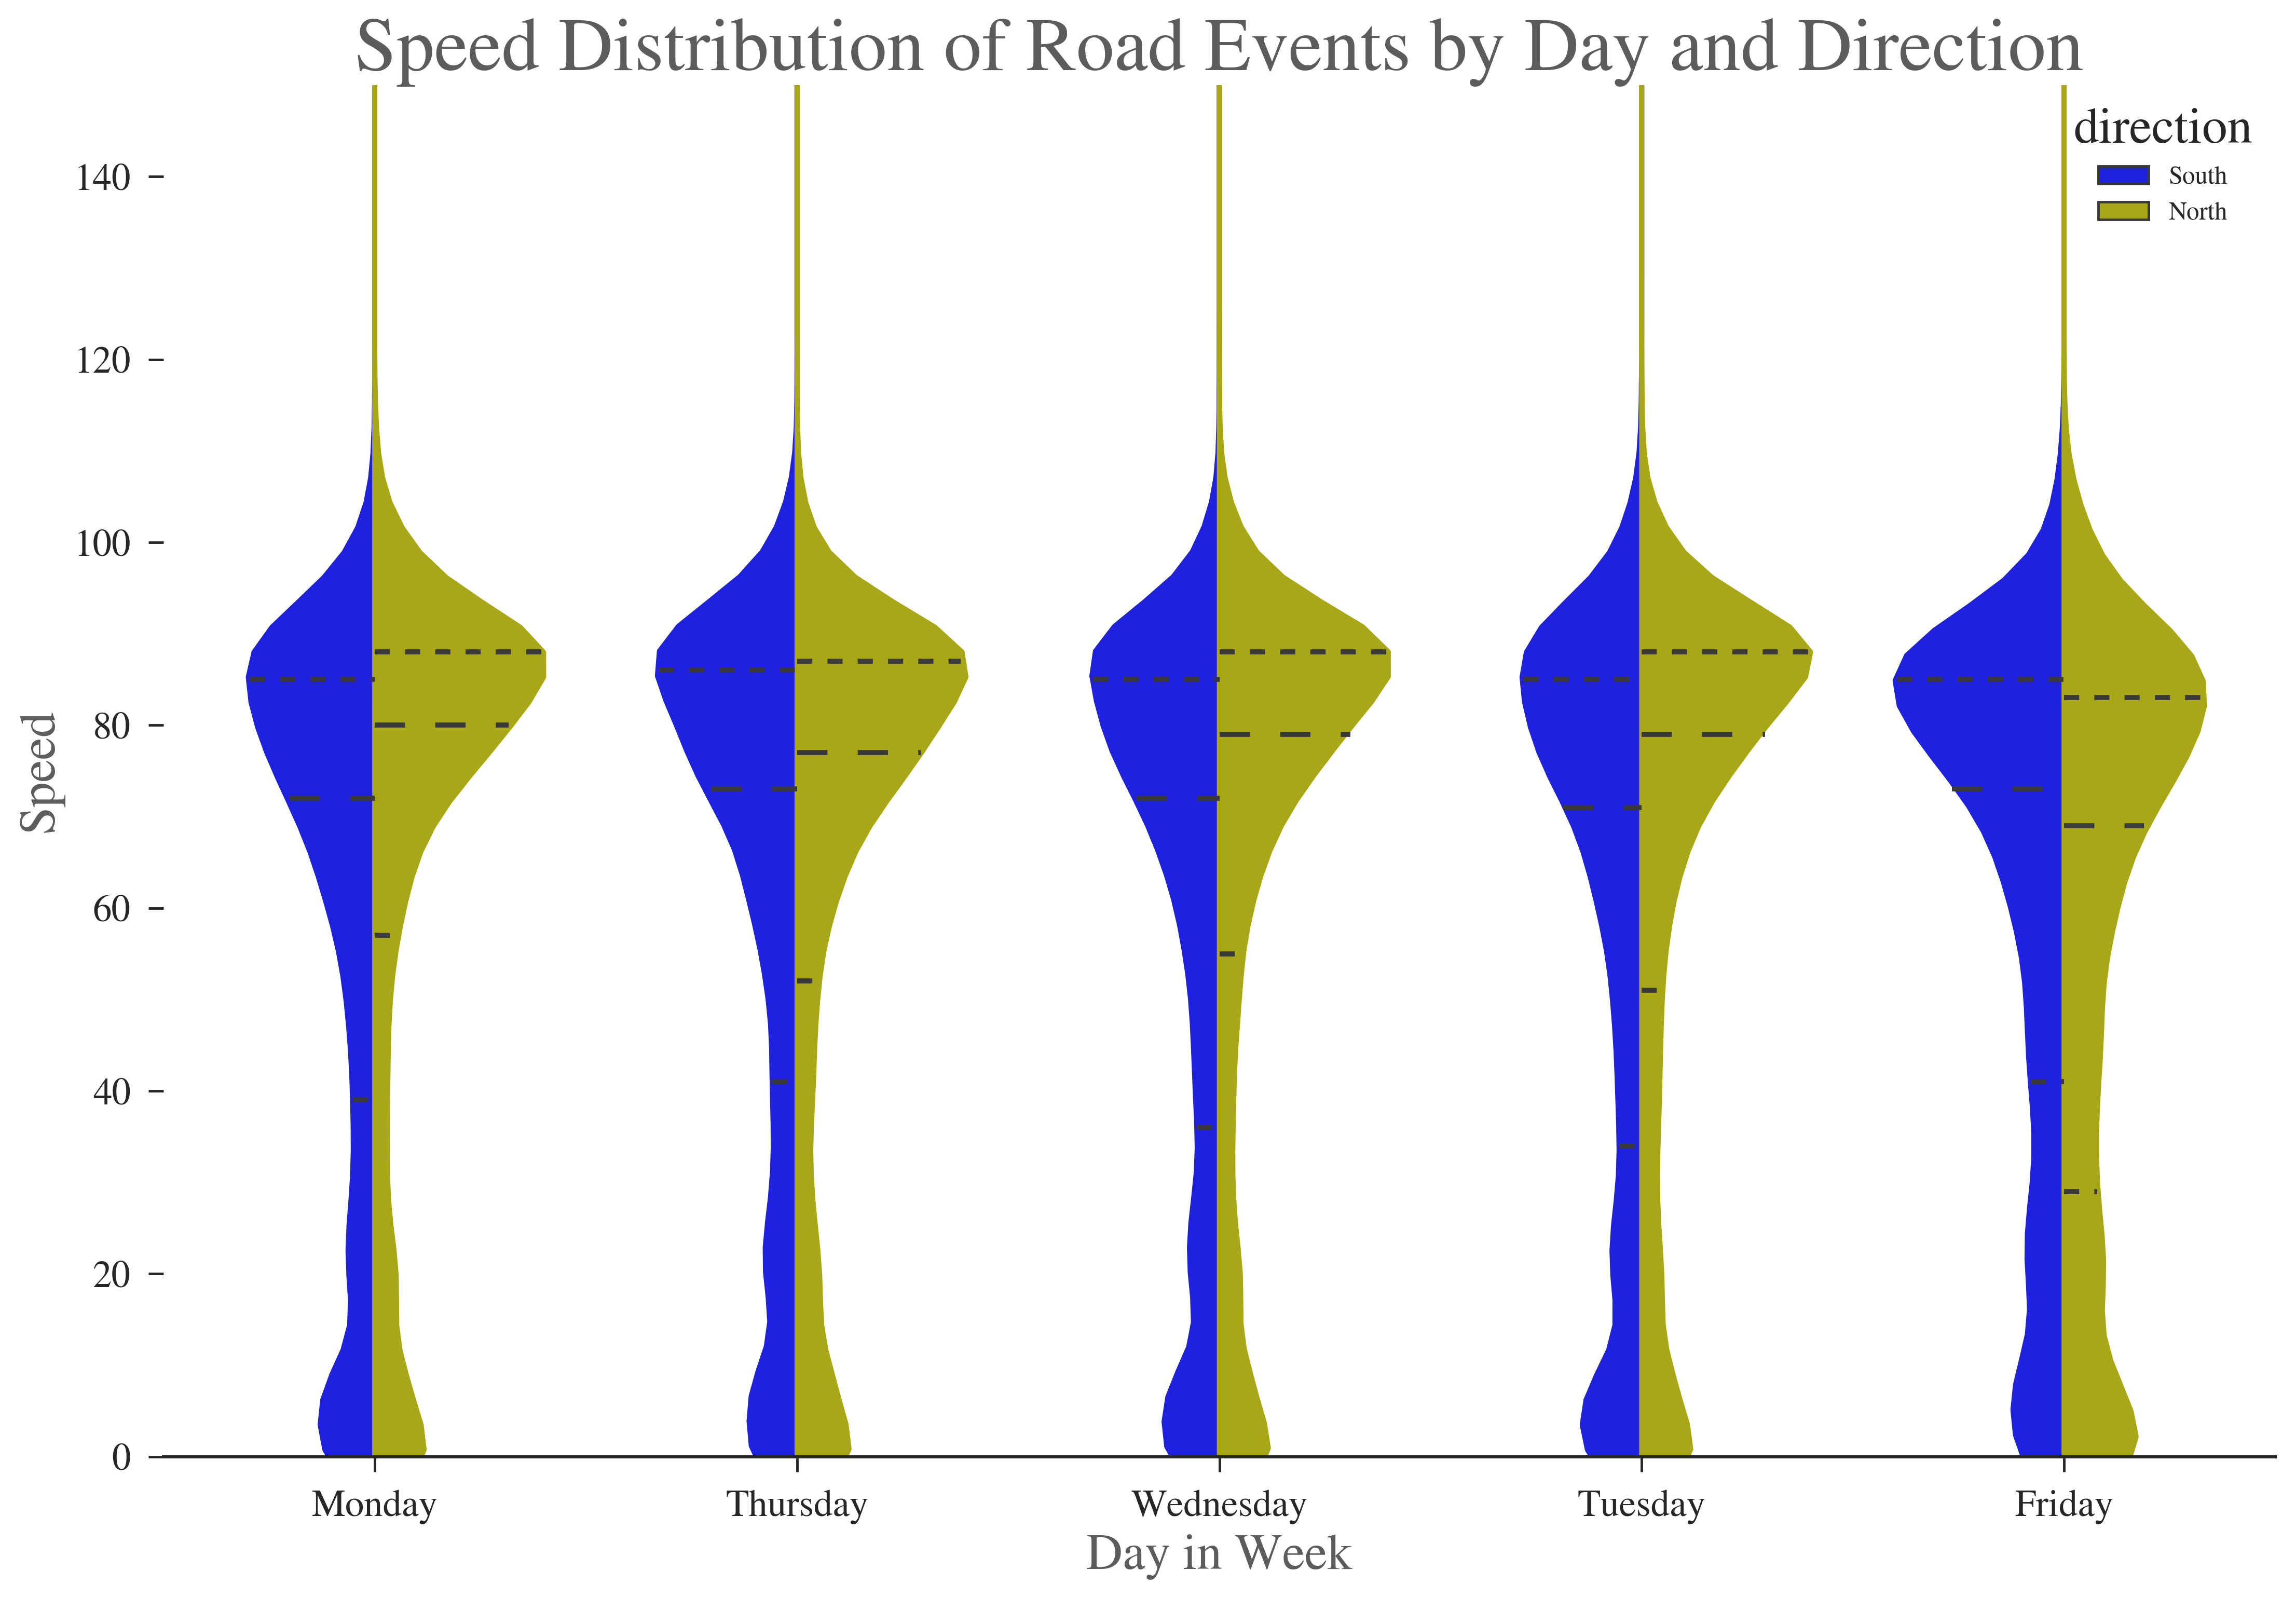

In [165]:

fig, ax = plt.subplots(figsize=(15,10))
rcParams['font.size'] = 20
sns.violinplot(ax=ax, x="what_day", y="speed_gps_kph", hue="direction", data=df_machine_data_weekday, split=True,
               inner="quart", palette={"South": "b", "North": "y"})
sns.despine(left=True)
plt.title('Speed Distribution of Road Events by Day and Direction', alpha=0.75, fontsize=30)
plt.ylabel('Speed', alpha=0.75)
plt.xlabel('Day in Week', alpha=0.75)
plt.ylim([0,150])

The figure shows speed distribution based on direction and week day, the result reflects that during Monday to Tuesday, vehicles moving towards North are usually a little faster than vehicles moving towards South, however, on Friday, vehicles moving to South are faster.

### Analyse on Speed and Weight Type by Day

(0, 150)

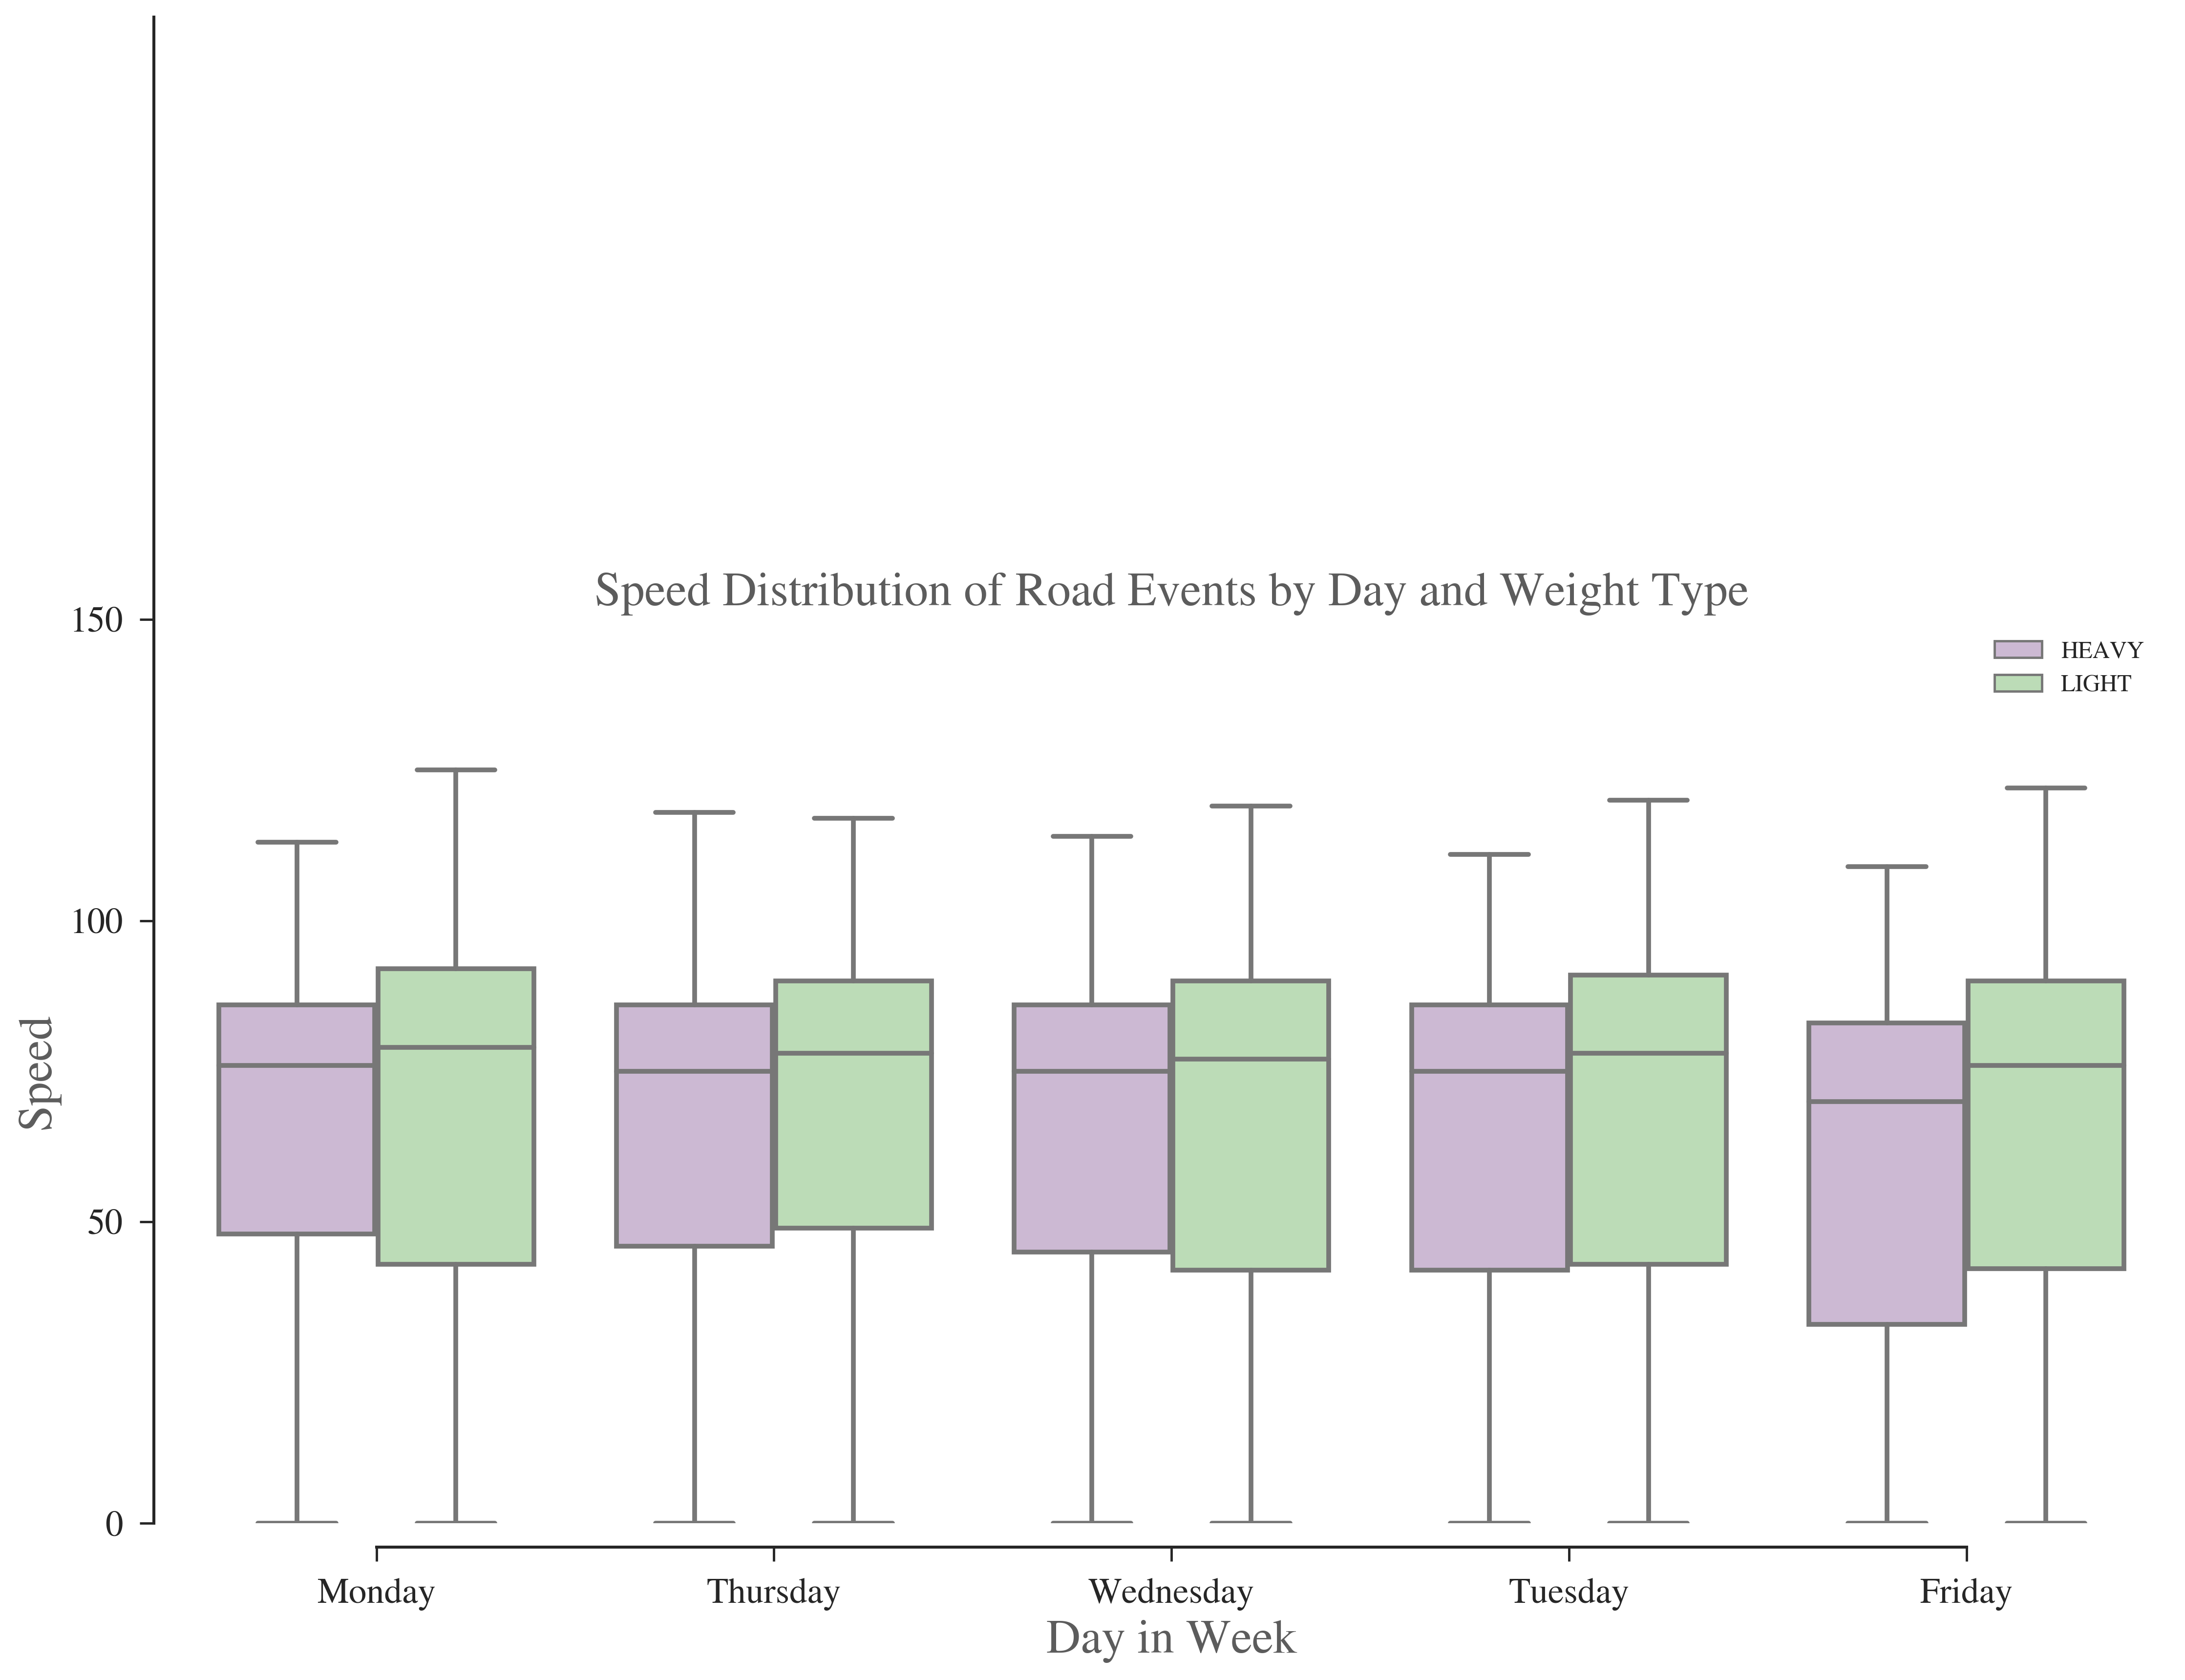

In [166]:
fig, ax = plt.subplots(figsize=(15,7))
sns.boxplot(x="what_day", y="speed_gps_kph", hue="vehicle_weight_type", data= df_machine_data_weekday_weight, palette="PRGn")
sns.despine(offset=10, trim=True)
plt.title('Speed Distribution of Road Events by Day and Weight Type', alpha=0.75, fontsize=20)
plt.ylabel('Speed', alpha=0.75, fontsize=20)
plt.xlabel('Day in Week', alpha=0.75, fontsize=20)
plt.legend( loc='upper right', numpoints = 1 )
plt.ylim([0,150])

The figure shows speed distribution based on weight type and week day, the result reflects that on any day, the light vehicles are more likely to be faster than heavy vehicles.
That is reasonable since in real world, heavy trucks are usually slower than light cars.

### Analyse on Event Location

The road events data provides detailed location by latitude and longitude, it could be used to display the shape of the road.

In [167]:
df_machine_data['longitude'] = pd.to_numeric(df_machine_data['longitude'], errors='coerce')
df_machine_data['latitude'] = pd.to_numeric(df_machine_data['latitude'], errors='coerce')

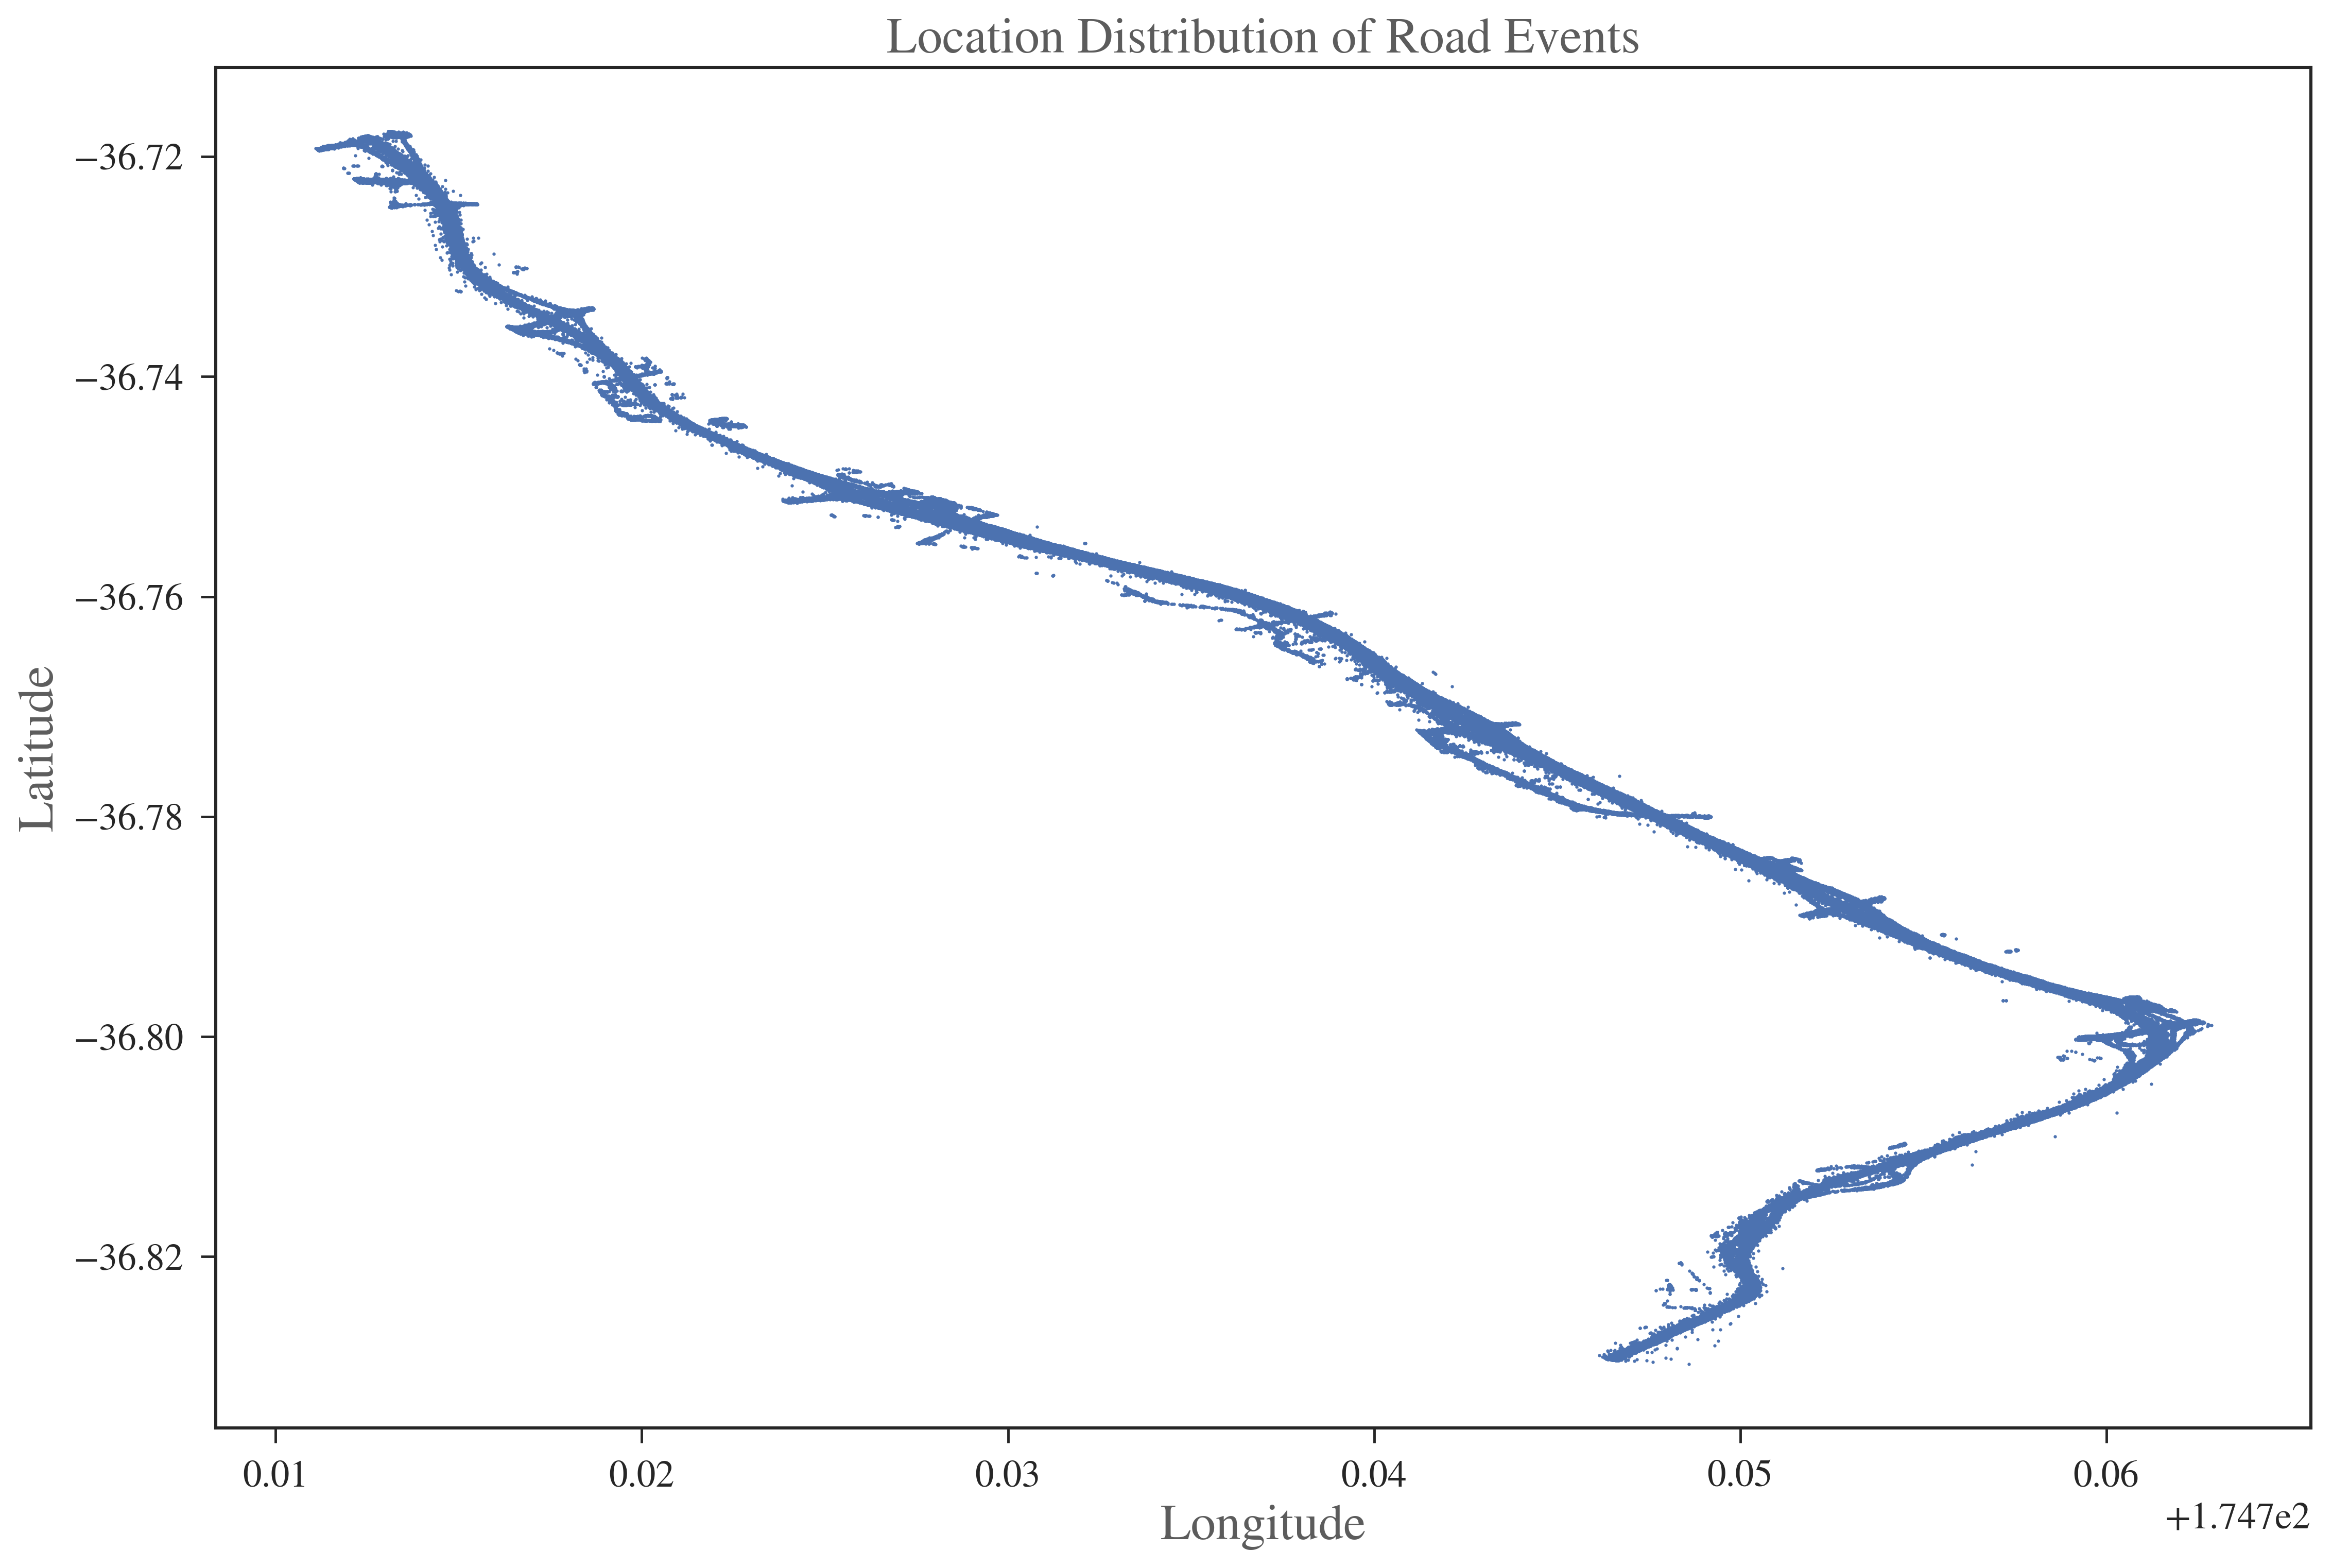

In [168]:

fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(df_machine_data.longitude, df_machine_data.latitude, s=1)
plt.title('Location Distribution of Road Events', alpha=0.75, fontsize=20)
plt.ylabel('Latitude', alpha=0.75, fontsize=20)
plt.xlabel('Longitude', alpha=0.75, fontsize=20)

The scatter figure shows the outline of Northern Motorway in map. We compare the map with real google map of this road, the outline of the map matches the real road ignoring the x-axis scaling. 

Here we've analysed the zip file of road events by different columns, in next section, we will analyse the road segments data.

## Northern Motorway Road Segments

We we got the estimated map of Northern Motorway, the file 'Northern Motorway Road Segments.csv' contains segmentation information of the road, so we are now trying to display different segments with different colors. 

### Prepare Data

In [169]:
df_segments_data=pd.read_csv('Northern Motorway Road Segments.csv',';')
df_segments_data.head(5)

id      full_name                                   road_segment_wkt
0  606114469  Northern Mtwy  LINESTRING(174.76028 -36.80417,174.76041 -36.8...
1  606114470  Northern Mtwy  LINESTRING(174.76043 -36.80419,174.76053 -36.8...
2  606114471  Northern Mtwy  LINESTRING(174.76009 -36.80453,174.76028 -36.8...
3  606114472  Northern Mtwy  LINESTRING(174.76022 -36.80458,174.76043 -36.8...
4  605961478  Northern Mtwy  LINESTRING(174.74429 -36.77469,174.74387 -36.7...

In [170]:
# Print all segment names
df_segments_data.full_name.unique()

array(['Northern Mtwy', '417', nan, 'Northern Busway', '421', '420', '412',
       '414', '410', '422', '419'], dtype=object)

In the dataset, the full name 417, 414, 410, 422 and 419 are exits of the road, they only contain one location information while 'Northern Mtwy' contains two. The rows without a full name represent entries, they also contain only one location. 
To identify different types of road segments, we classify them by full name with a function.

In [171]:
def getTypeFromName(name):
    if str(name) == 'nan' or len(str(name)) == 0:
        return 'Entry'      # without a full name
    elif name != 'Northern Mtwy' and name != 'Northern Busway':   # Exit
        return 'Exit'
    else :
        return name


Add new column 'seg_type'.

In [172]:
df_segments_data['seg_type'] = df_segments_data.full_name.apply(lambda x: getTypeFromName(x))
df_segments_data.head(5)

id      full_name  \
0  606114469  Northern Mtwy   
1  606114470  Northern Mtwy   
2  606114471  Northern Mtwy   
3  606114472  Northern Mtwy   
4  605961478  Northern Mtwy   

                                    road_segment_wkt       seg_type  
0  LINESTRING(174.76028 -36.80417,174.76041 -36.8...  Northern Mtwy  
1  LINESTRING(174.76043 -36.80419,174.76053 -36.8...  Northern Mtwy  
2  LINESTRING(174.76009 -36.80453,174.76028 -36.8...  Northern Mtwy  
3  LINESTRING(174.76022 -36.80458,174.76043 -36.8...  Northern Mtwy  
4  LINESTRING(174.74429 -36.77469,174.74387 -36.7...  Northern Mtwy

Next we need to format column 'road_segment_wkt', every row contains one or two location information, so we define 4 new columns: segment_start_longitude, segment_stop_longitude, segment_start_latitude and segment_stop_latitude. The value could be extract from column 'road_segment_wkt'.

In [173]:
df_segments_data['seg_type'].unique()

array(['Northern Mtwy', 'Exit', 'Entry', 'Northern Busway'], dtype=object)

In [174]:
# First, remove unused characters
df_segments_data['road_segment_wkt']=df_segments_data['road_segment_wkt'].str.replace('LINESTRING\(','').str.replace('\)','')
df_segments_data.head(5)

id      full_name  \
0  606114469  Northern Mtwy   
1  606114470  Northern Mtwy   
2  606114471  Northern Mtwy   
3  606114472  Northern Mtwy   
4  605961478  Northern Mtwy   

                                    road_segment_wkt       seg_type  
0            174.76028 -36.80417,174.76041 -36.80389  Northern Mtwy  
1            174.76043 -36.80419,174.76053 -36.80397  Northern Mtwy  
2            174.76009 -36.80453,174.76028 -36.80417  Northern Mtwy  
3            174.76022 -36.80458,174.76043 -36.80419  Northern Mtwy  
4  174.74429 -36.77469,174.74387 -36.77401,174.74...  Northern Mtwy

The segments may contains several points, it could provide cornor information, store them in new columns 'longitude_list' and 'latitude_list'.

In [175]:
add_cols = ['longitude_list', 'latitude_list']

In [176]:
# extract the min/max longitude and latitude to define the segment area
def extractLocations(skt):
    minLong = 10000.0
    maxLong = -10000.0
    minLati = 10000.0
    maxLati = -10000.0
    longitude_list = []
    latitude_list = []
    locationArray = skt.split(',')
    for location in locationArray:
        Long_lati = location.split(' ')
        longitude = float(Long_lati[0])
        latitude = float(Long_lati[1])
        longitude_list.append(longitude)
        latitude_list.append(latitude)
        if(minLong > longitude):
            minLong = longitude
        if(maxLong < longitude):
            maxLong = longitude
        if(minLati > latitude):
            minLati = latitude
        if(maxLati < latitude):
            maxLati = latitude
    return [longitude_list,latitude_list]

In [177]:
lambdafunc = lambda x: pd.Series(extractLocations(x))

In [178]:
newcols = df_segments_data.road_segment_wkt.apply(lambdafunc)
newcols.columns = add_cols
df_segments_data = df_segments_data.join(newcols) 
df_segments_data.head(5)


id      full_name  \
0  606114469  Northern Mtwy   
1  606114470  Northern Mtwy   
2  606114471  Northern Mtwy   
3  606114472  Northern Mtwy   
4  605961478  Northern Mtwy   

                                    road_segment_wkt       seg_type  \
0            174.76028 -36.80417,174.76041 -36.80389  Northern Mtwy   
1            174.76043 -36.80419,174.76053 -36.80397  Northern Mtwy   
2            174.76009 -36.80453,174.76028 -36.80417  Northern Mtwy   
3            174.76022 -36.80458,174.76043 -36.80419  Northern Mtwy   
4  174.74429 -36.77469,174.74387 -36.77401,174.74...  Northern Mtwy   

                                      longitude_list  \
0                             [174.76028, 174.76041]   
1                             [174.76043, 174.76053]   
2                             [174.76009, 174.76028]   
3                             [174.76022, 174.76043]   
4  [174.74429, 174.74387, 174.74337, 174.74301, 1...   

                                       latitude_list  
0                             [-36.80417, -36.80389]  
1                             [-36.80419, -36.80397]  
2                             [-36.80453, -36.80417]  
3                             [-36.80458, -36.80419]  
4  [-36.77469, -36.77401, -36.77316, -36.77252, -...

Now we have marked different segments with different types, and got every part of segment for display, we can show the map by segment types.

/home/yrao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


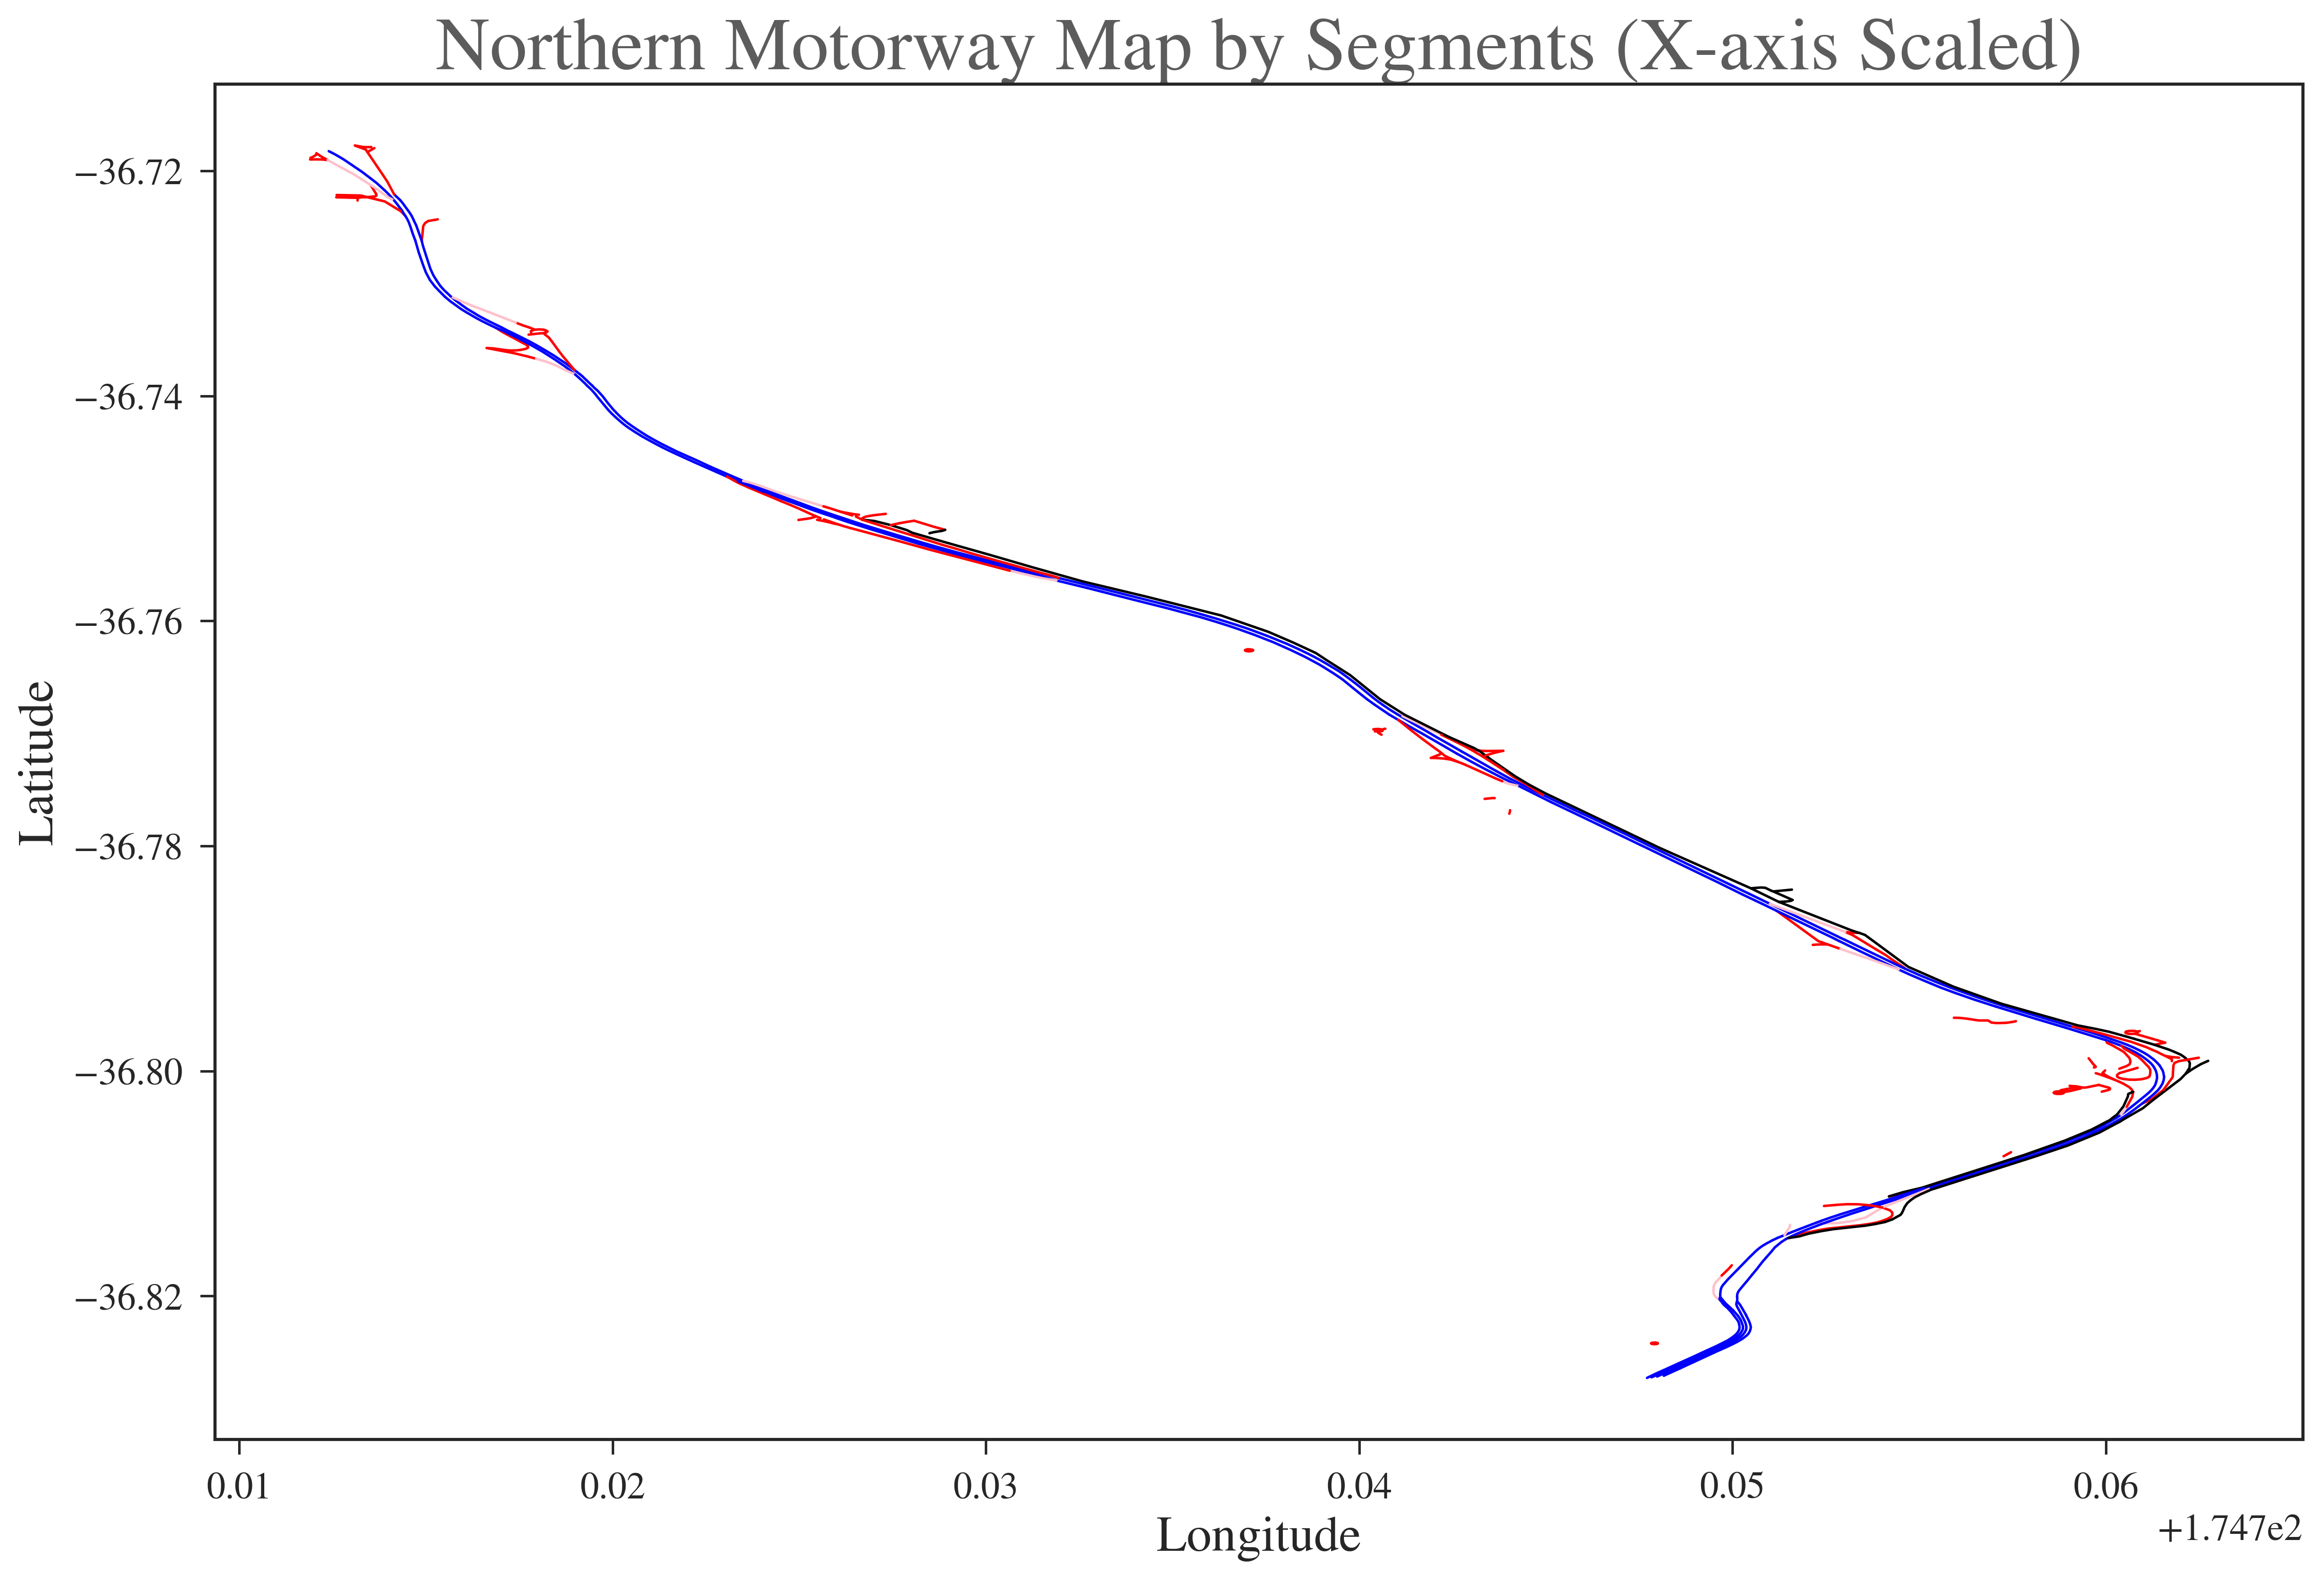

In [179]:
type_color_map = {'Northern Mtwy':'blue', 'Entry':'red', 'Exit':'pink', 'Northern Busway':'black'}

fig, ax = plt.subplots(figsize=(15,10))
for i in df_segments_data.index:
    x = df_segments_data.ix[i]['longitude_list']
    y = df_segments_data.ix[i]['latitude_list']
    seg_type = df_segments_data.ix[i]['seg_type']
    color = type_color_map[seg_type]
    plt.plot(x, y, color,linewidth = 1.0)
plt.title('Northern Motorway Map by Segments (X-axis Scaled)', alpha=0.75, fontsize=30)
plt.ylabel('Latitude')
plt.xlabel('Longitude')



From the figure above, we can clearly see the different segments of the road.

## Predictive Models

As traffic situation of weekend is very likely to be different with weekday, so we will analyse weekday only. First we will predict speed according to time and direction, then we will try to predict direction with time and speed.

### Predict Speed According to Time and Direction(South or North) -- KNN Model

We need to build KNN models for both north and south directions

In [180]:
df_machine_data_weekday_S.head(1)

id     event_timestamp  course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                 153      21564   

  vehicle_weight_type  speed_gps_kph    latitude   longitude what_day  period  \
0               HEAVY             77  -36.776549  174.745603   Monday       8   

  direction  
0     South

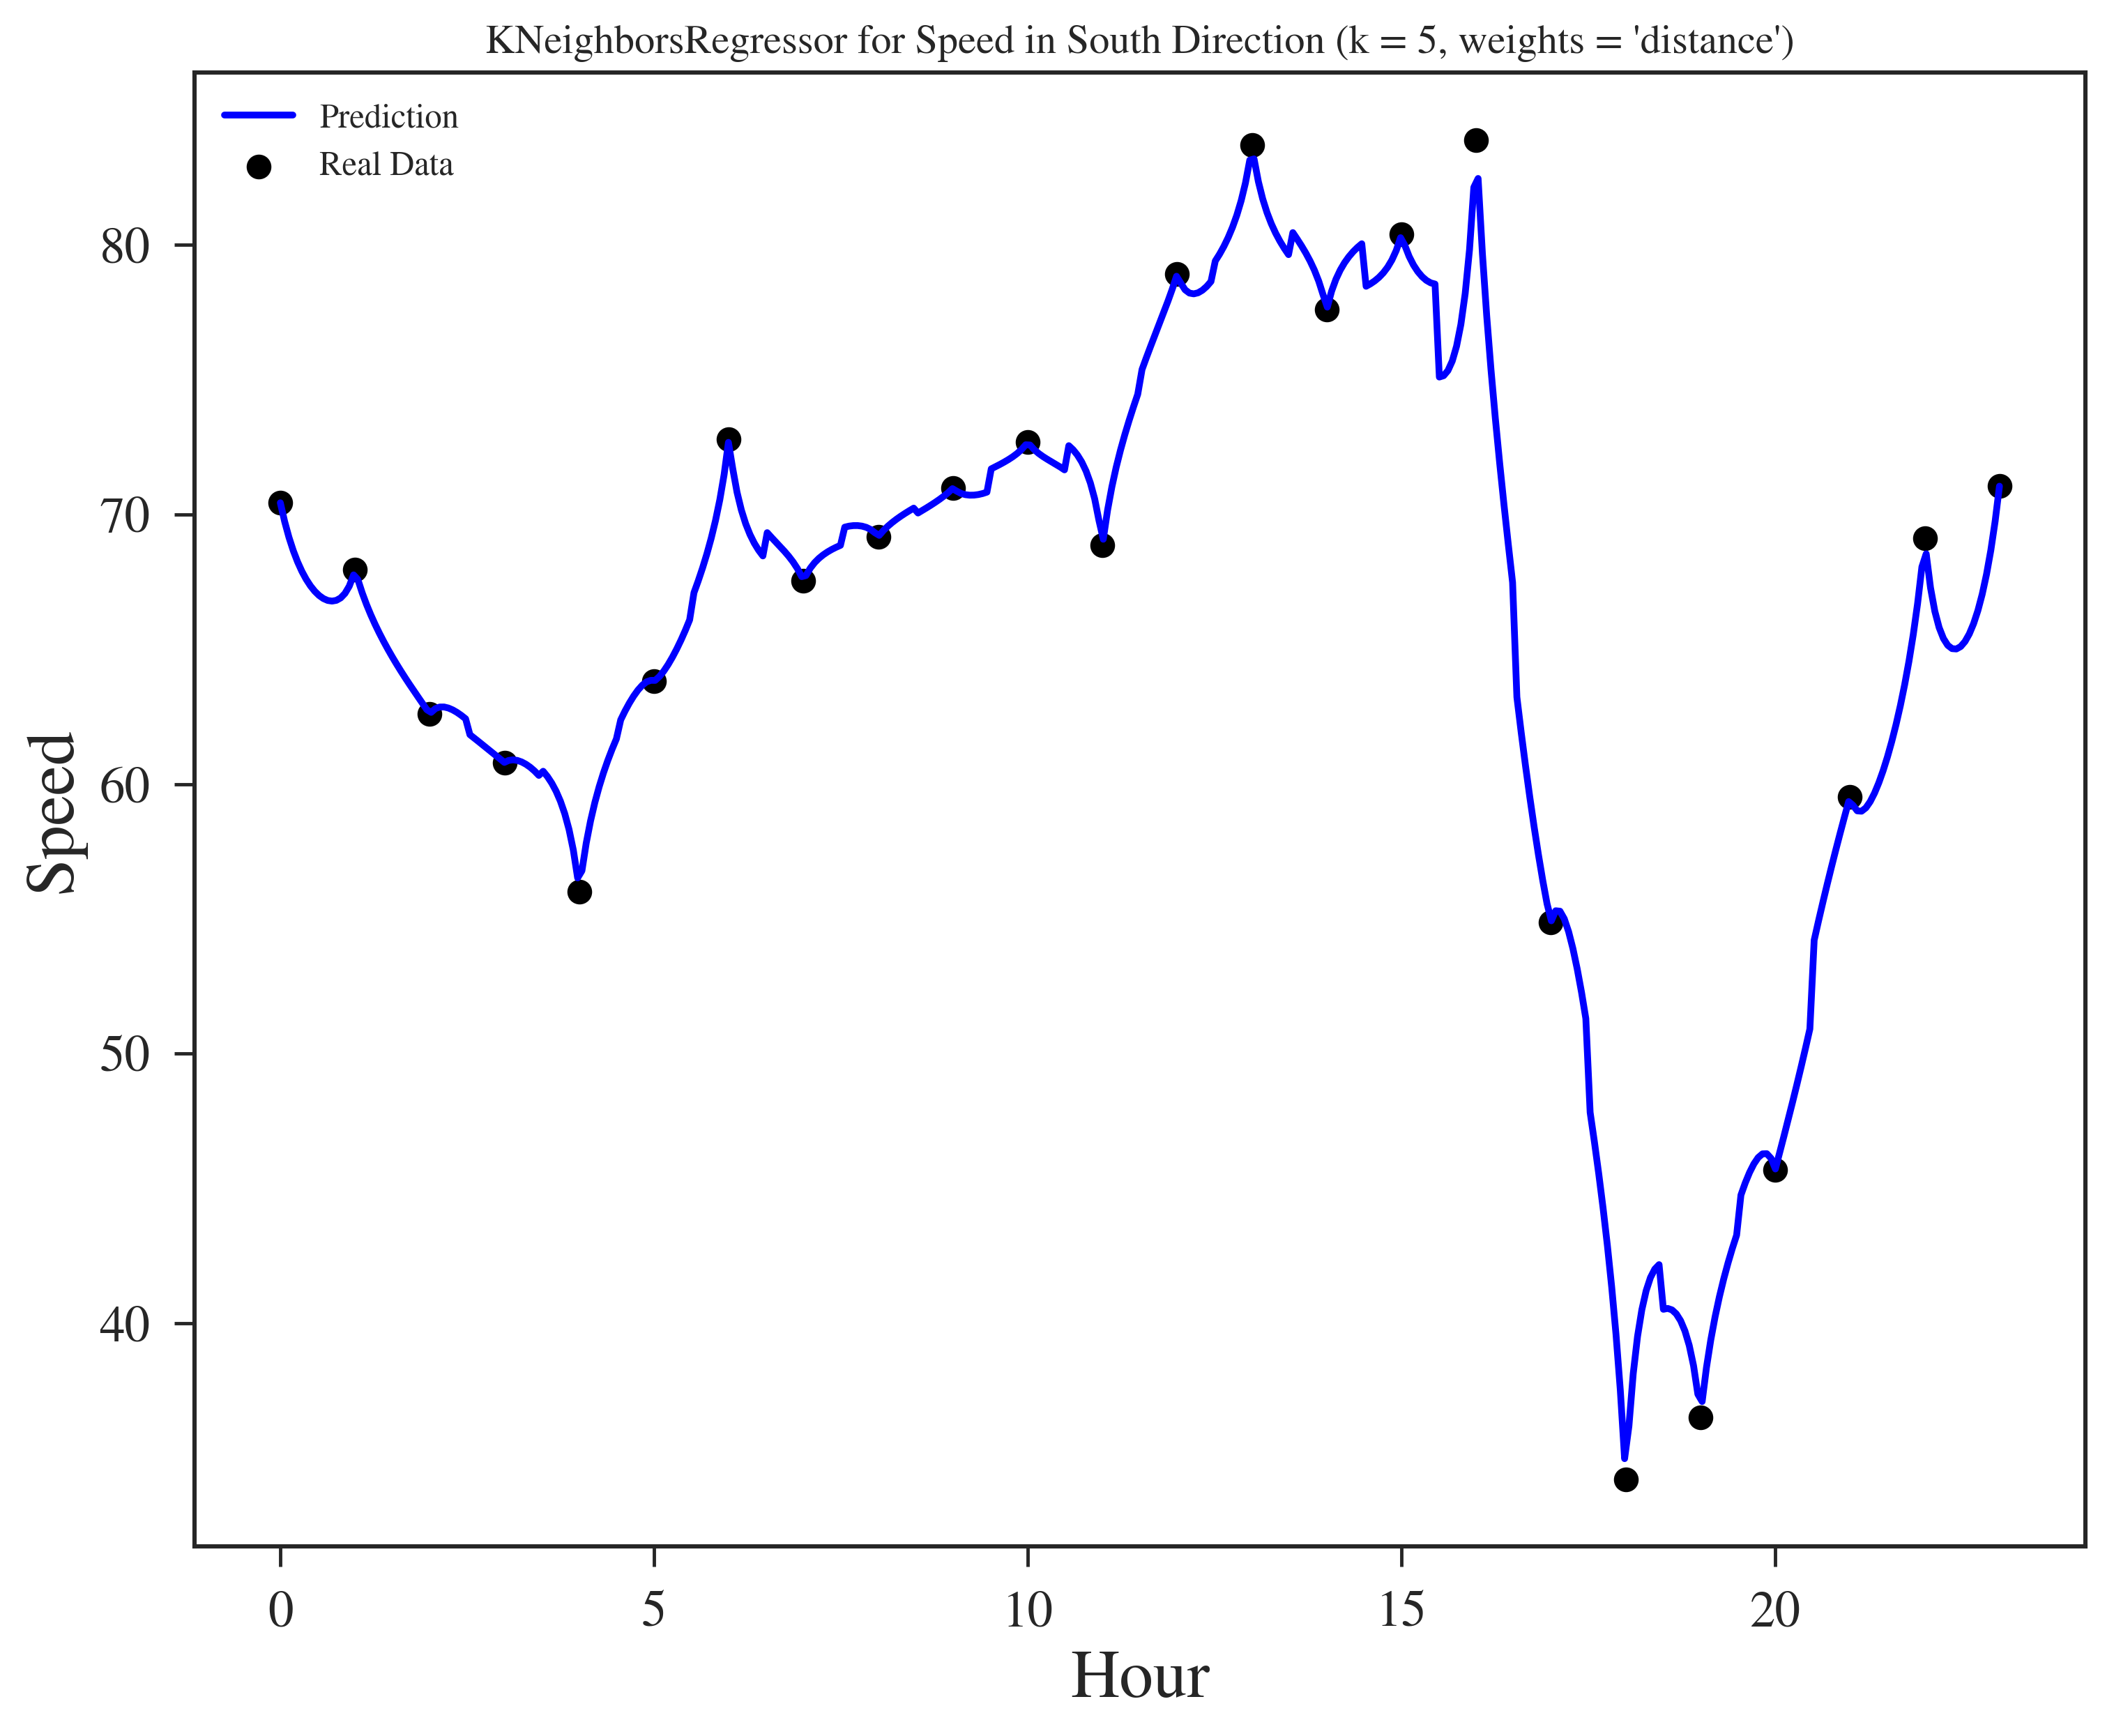

In [181]:
n_neighbors = 5
south_speed_mod = 0
weights='distance'
    
X = grouped_count_S.index.values
X = np.reshape(X, (len(X), 1))
y = grouped_count_S.values
y = np.reshape(y, (len(y), 1))
x = np.linspace(X.min(), X.max(), 400)[:, np.newaxis]

knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
south_speed_mod = knn.fit(X, y)
y_hat = south_speed_mod.predict(x)
#plt.subplot(2, 1, i + 1)
plt.scatter(X, y, c='k', label='Real Data')
plt.plot(x, y_hat, 'b-', c='b', label='Prediction')
plt.axis('tight')
plt.xlabel('Hour')
plt.ylabel('Speed')
plt.legend(loc='upper left')
plt.title("KNeighborsRegressor for Speed in South Direction (k = %i, weights = '%s')" % (n_neighbors, weights))
plt.show()

In [182]:
# Let's predict the speed at 09:00 am on 2017-09-25(Monday)
time = '2017-09-25 09:00:00'
period =  pd.to_datetime(time).hour
result = south_speed_mod.predict(period)
print 'The speed to South on Northern Motorway Road at 2017-09-25 09:00:00 is predicted to be', result[0][0], 'km/h'

The speed to South on Northern Motorway Road at 2017-09-25 09:00:00 is predicted to be 70.9780760626 km/h


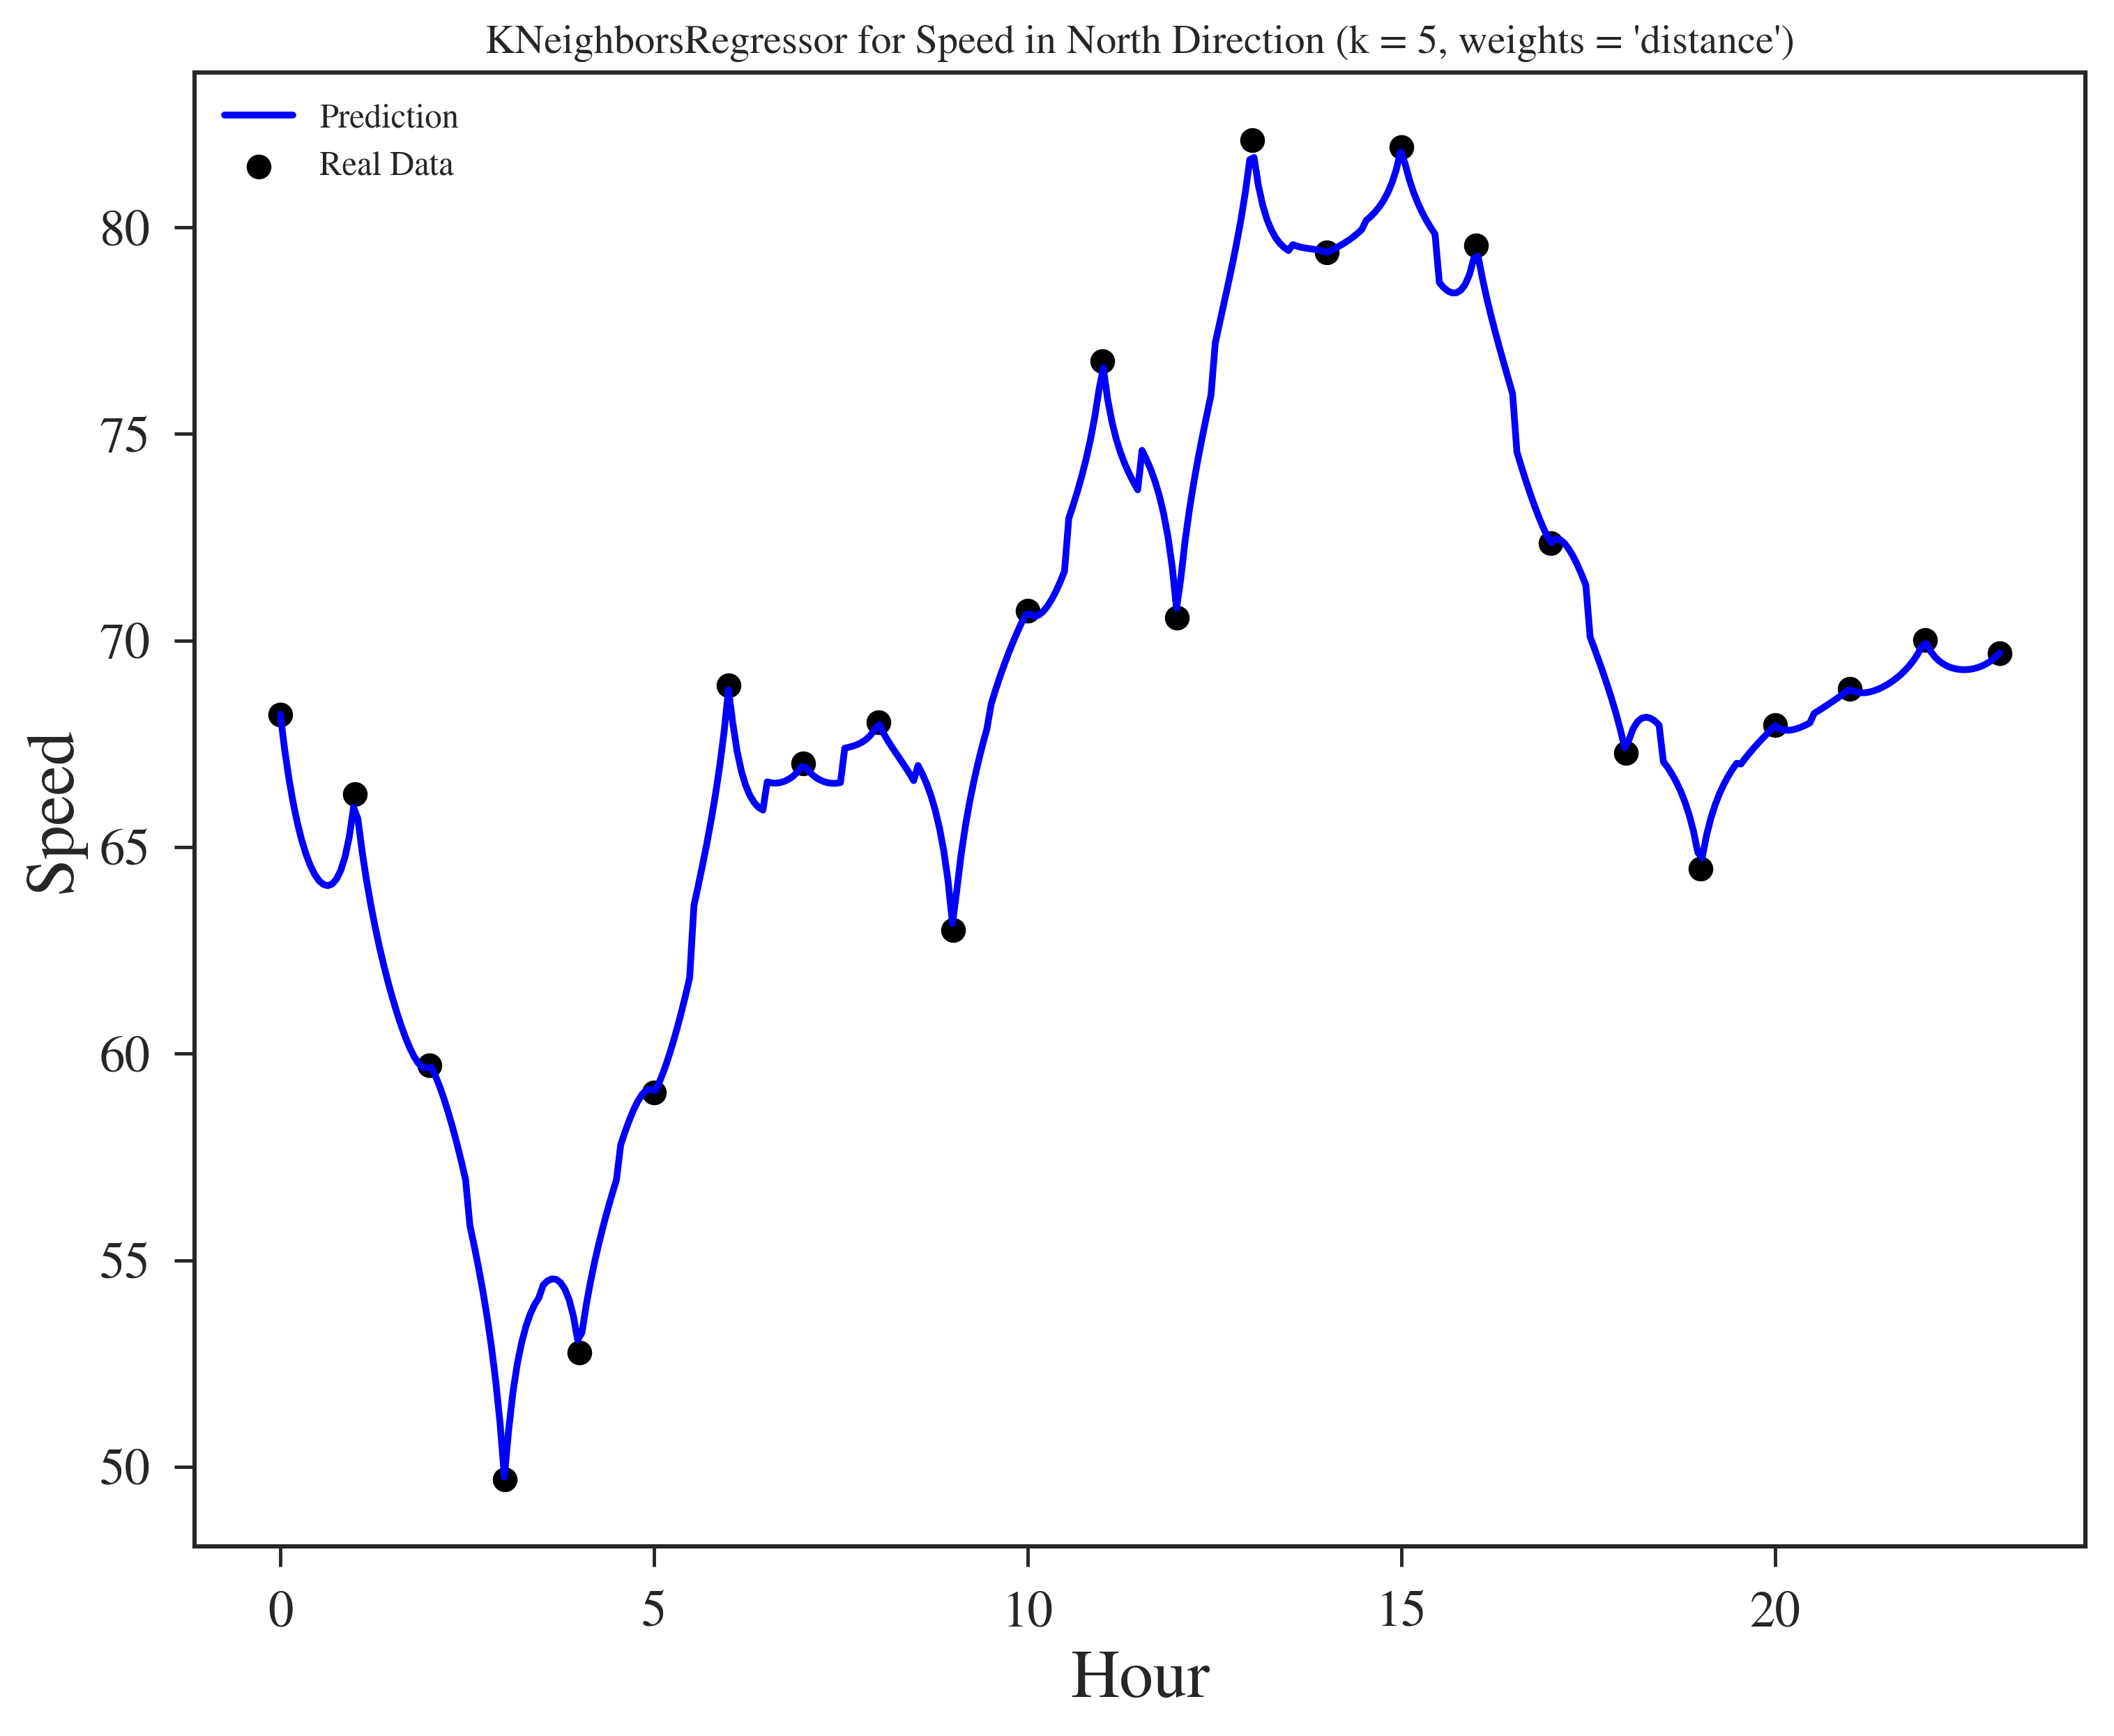

In [183]:
north_speed_mod = 0
    
X = grouped_count_N.index.values
X = np.reshape(X, (len(X), 1))
y = grouped_count_N.values
y = np.reshape(y, (len(y), 1))
x = np.linspace(X.min(), X.max(), 400)[:, np.newaxis]

knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
north_speed_mod = knn.fit(X, y)
y_hat = north_speed_mod.predict(x)
plt.scatter(X, y, c='k', label='Real Data')
plt.plot(x, y_hat, 'b-', c='b', label='Prediction')
plt.axis('tight')
plt.xlabel('Hour')
plt.ylabel('Speed')
plt.legend(loc='upper left')
plt.title("KNeighborsRegressor for Speed in North Direction (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.show()

In [184]:
# Let's predict the speed at 09:00 am on 2017-09-25(Monday)
time = '2017-09-25 09:00:00'
period =  pd.to_datetime(time).hour
result = north_speed_mod.predict(period)
print 'The speed to North on Northern Motorway Road at 2017-09-25 09:00:00 is predicted to be', result[0][0], 'km/h'

The speed to North on Northern Motorway Road at 2017-09-25 09:00:00 is predicted to be 62.9935622318 km/h


### Predict Direction According to Time and Speed -- Naive Bayes

In [185]:
df_machine_data_weekday.head(1)

id     event_timestamp  course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                 153      21564   

  vehicle_weight_type  speed_gps_kph    latitude   longitude what_day  period  \
0               HEAVY             77  -36.776549  174.745603   Monday       8   

  direction  
0     South

In [186]:
def pdf_gaussian(x, mean, std):
        return(1/(std*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mean)/std)**2))

# The fuction will traverse all rows in df_machine_data_weekday, it may take several minutes
def predict_direction(speed, period):
    result = 'North'
    north_array = []
    south_array = []
    for index, row in df_machine_data_weekday.iterrows():
         if row['period'] == period:
            if row['direction'] == "North":
                north_array.append(row['speed_gps_kph'])
            else:
                south_array.append(row['speed_gps_kph'])
    north_mean = np.mean(north_array) # mean speed
    north_std = np.std(north_array)   # std value
    south_mean = np.mean(south_array) # mean speed
    south_std = np.std(south_array)   # std values
    # Get gaussian probability density for both North and South
    north_prob = pdf_gaussian(speed, north_mean, north_std)
    south_prob = pdf_gaussian(speed, south_mean, south_std)
    if north_prob < south_prob: 
         result = 'South'
    return result

Let's check wether the gaussian model works well or not.

In [187]:
# Given Speed 77, time '2015-11-16 08:22:18', predict the direction
speed = 77 # The given speed
time = '2015-11-16 08:22:18'
period =  pd.to_datetime(time).hour
# It may take some time to finish predicting.
result = predict_direction(speed, period)
print "Given speed 77 and time 2015-11-16 08:22:18, the vehicle is predicted to direction: ", result

Given speed 77 and time 2015-11-16 08:22:18, the vehicle is predicted to direction:  South


Compare the predict result with the first row of df_machine_data_weekday, the predict result is correct.

### Predict Speed Based on Direction (Angle) -- Linear

We've built KNN and Naive Bayes models in previous parts, now we will try to build a linear model which is used tp predict speed based on direction.

In [188]:
len(df_machine_data)

569941

In [189]:
df_machine_data_top_1000 = df_machine_data.head(1000)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          speed_gps_kph   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     34.42
Date:                Tue, 26 Sep 2017   Prob (F-statistic):           6.03e-09
Time:                        00:03:27   Log-Likelihood:                -4974.6
No. Observations:                1000   AIC:                             9953.
Df Residuals:                     998   BIC:                             9963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             31.3280      2.121     14.768      0.000      27.165      35.491
course_over_ground     0.0553      0.009      5.867      0.000       0.037       0.074
==============================================================================
Omnibus:                        1.258   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.533   Jarque-Bera (JB):              110.821
Skew:                           0.086   Prob(JB):                     8.62e-25
Kurtosis:                       1.378   Cond. No.                         431.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

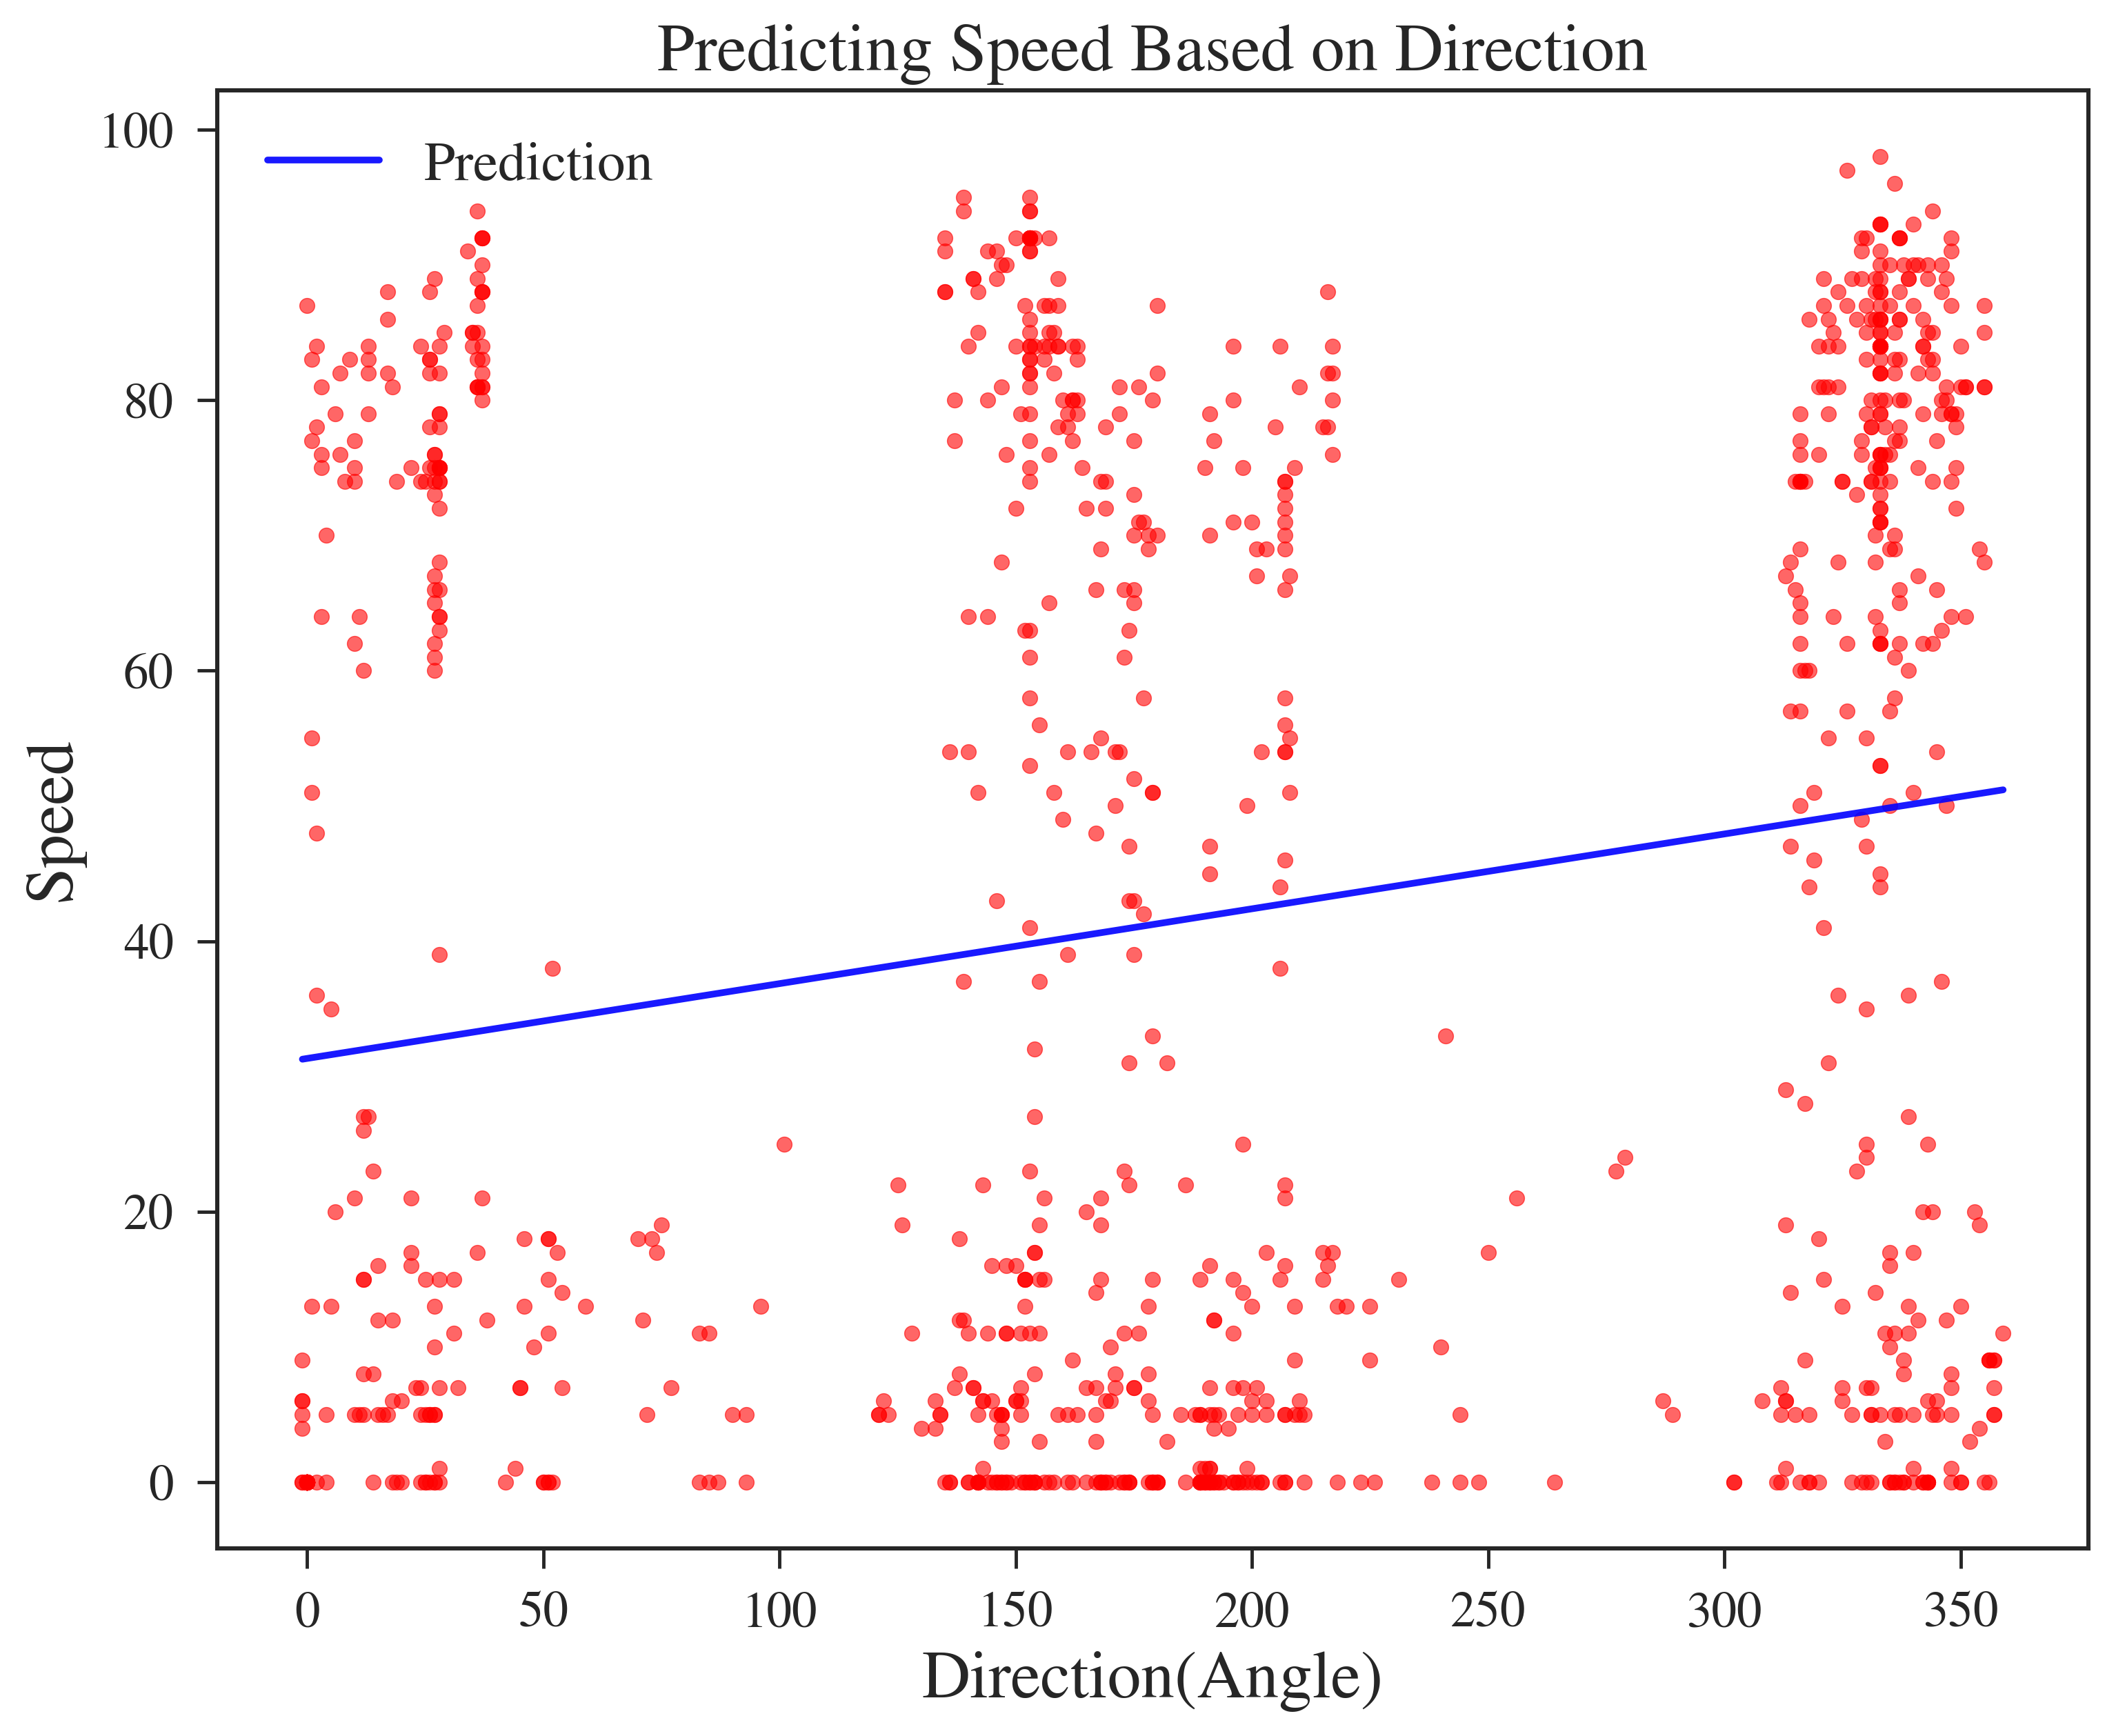

In [190]:
# The original data contains too may rows, we'd like to build model using the first 1000 rows

x = pd.DataFrame({'course_over_ground': np.linspace(df_machine_data_top_1000['course_over_ground'].min(), df_machine_data_top_1000['course_over_ground'].max(), len( df_machine_data_top_1000['course_over_ground']))})

#generate the model 
mod = smf.ols(formula='speed_gps_kph ~ 1 + course_over_ground', data=df_machine_data_top_1000.dropna()).fit()

#plot the actual data
plt.scatter(df_machine_data_top_1000.course_over_ground, df_machine_data_top_1000.speed_gps_kph, s=20,color='red', alpha=0.6, label = '')
plt.xlabel('Direction(Angle)');
plt.ylabel('Speed')
plt.plot(x, mod.predict(x), 'b-',  label='Prediction', alpha=0.9)

#give the figure a meaningful legend
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting Speed Based on Direction", fontsize=20)

mod.summary()

It is clear that the model could not predict speed properly, the points approach our linear model.

### Predict Speed Based on Direction (Angle) -- Polynomial Model

The linear model is not good, here we try polynomial model to predict speed based on direction.

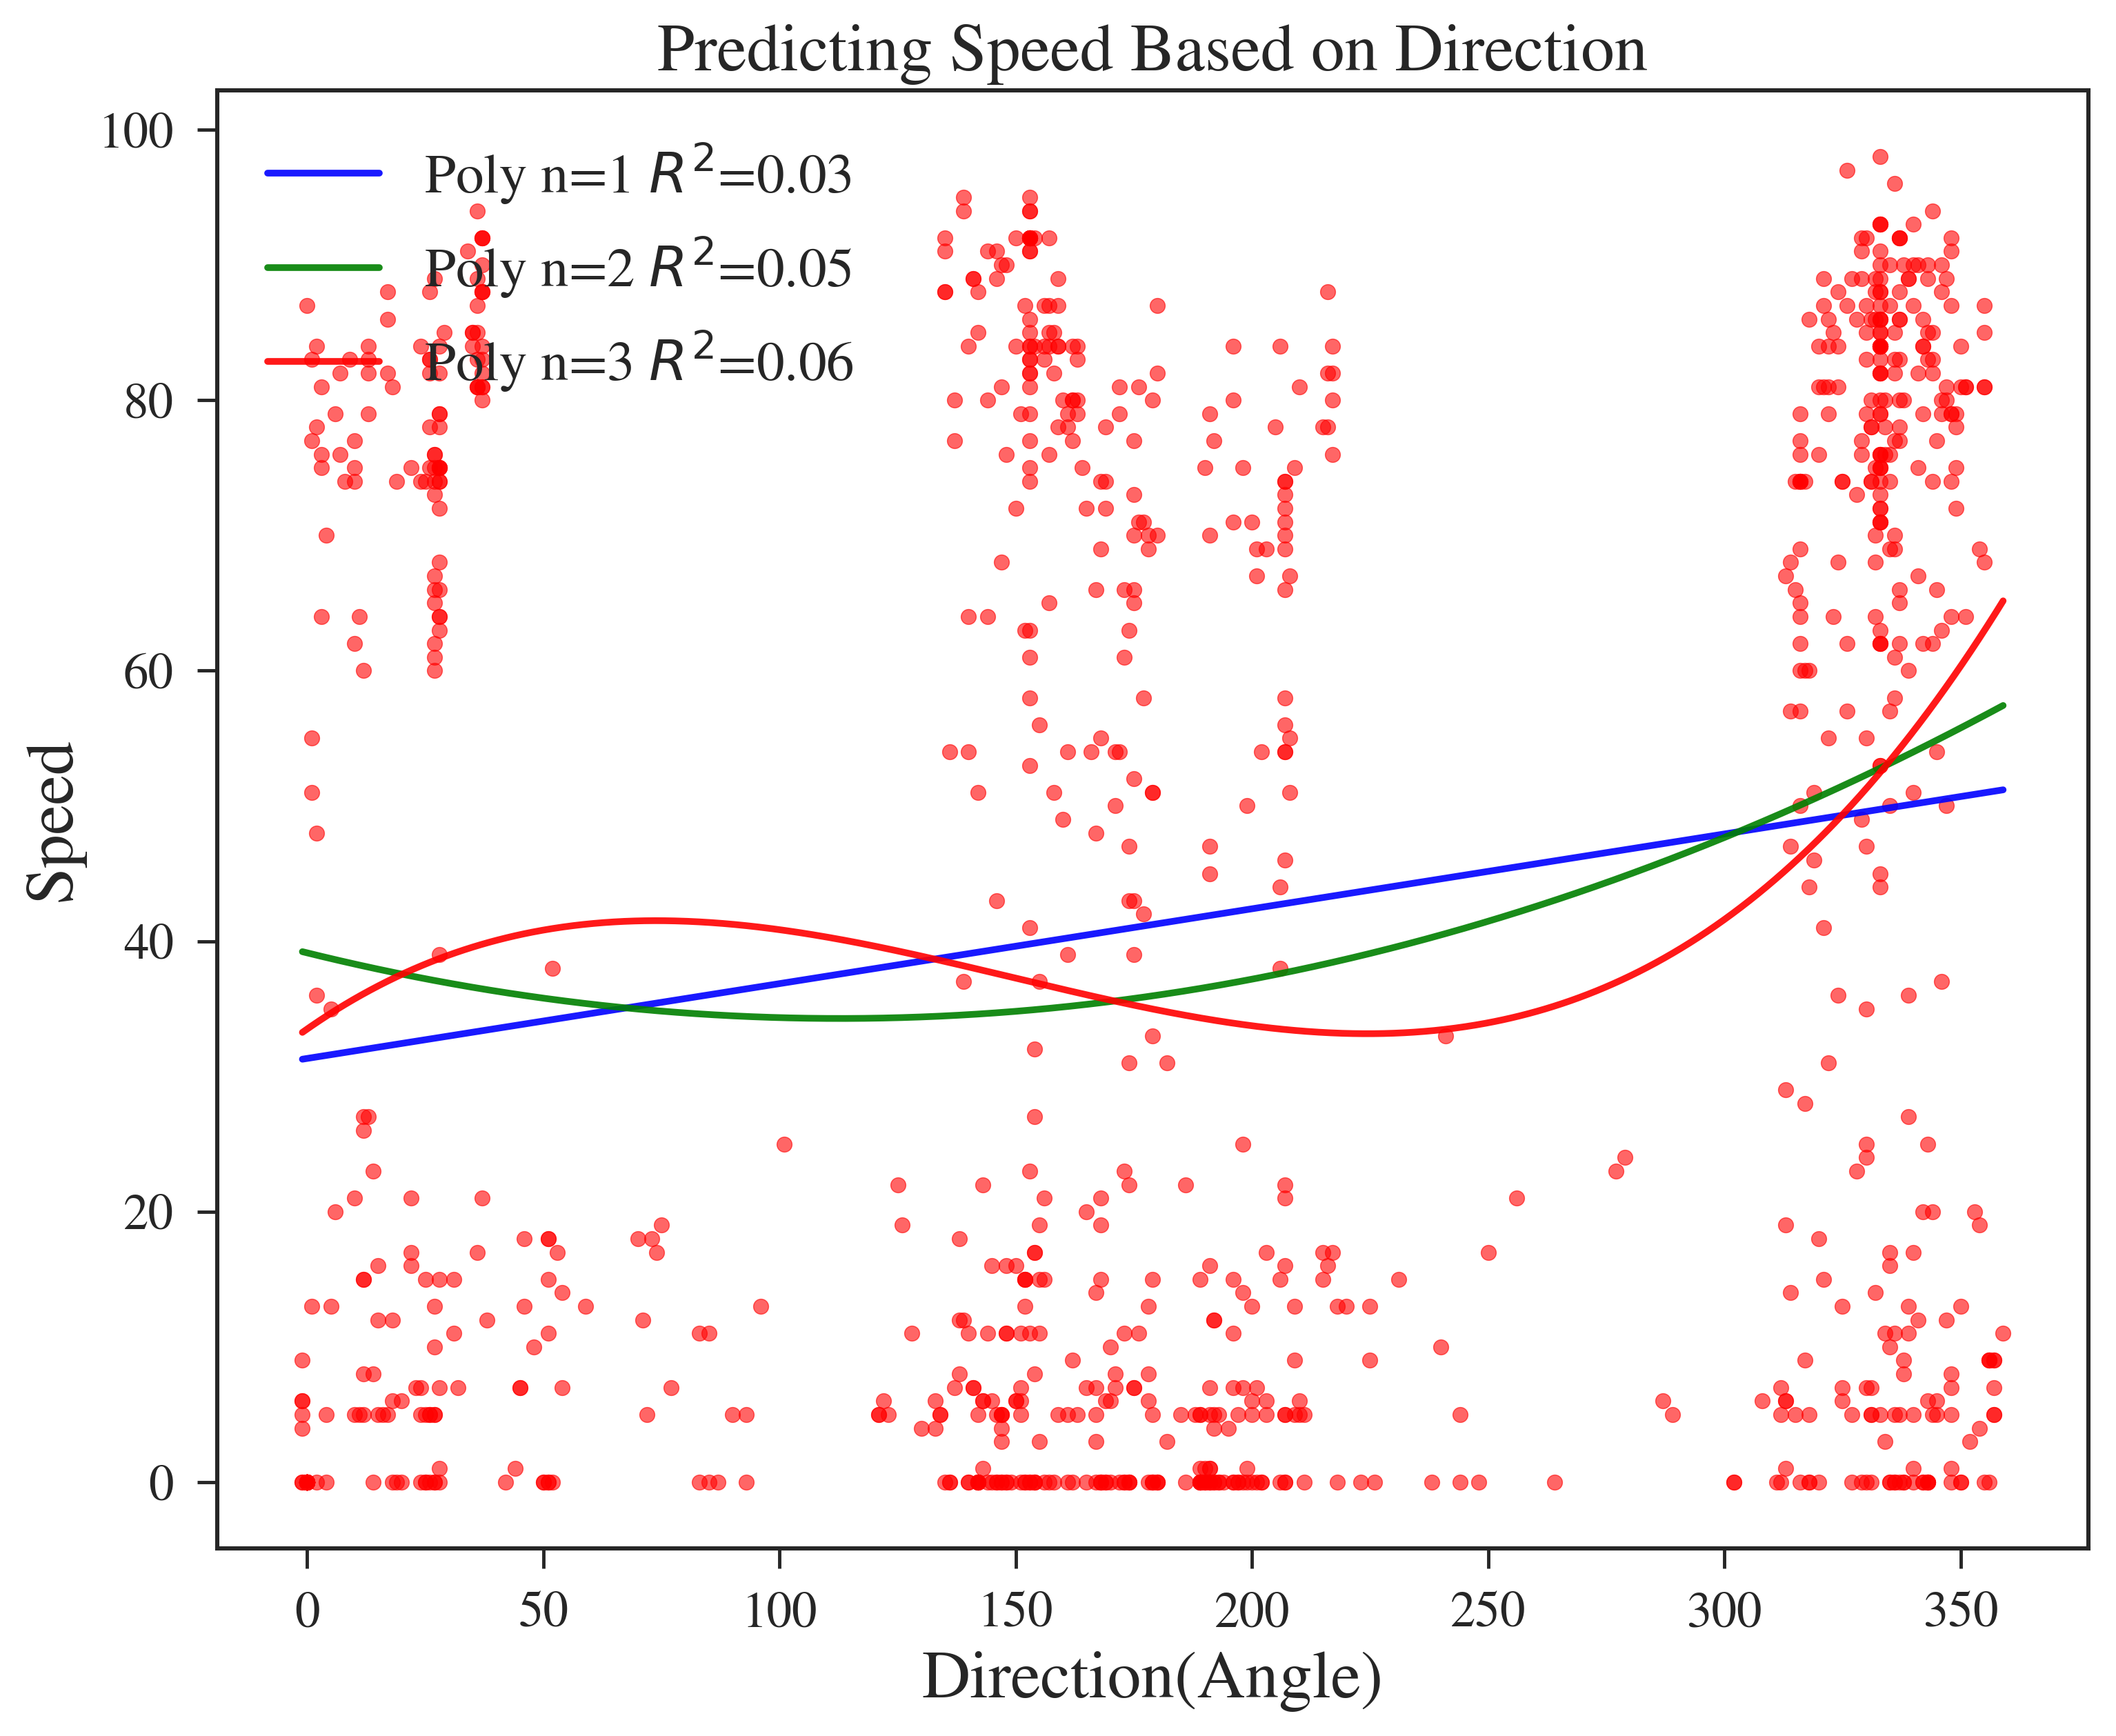

In [191]:

plt.xlabel('Direction(Angle)')
plt.ylabel('Speed')

x = pd.DataFrame({'course_over_ground': np.linspace(df_machine_data_top_1000['course_over_ground'].min(), df_machine_data_top_1000['course_over_ground'].max(), len( df_machine_data_top_1000['course_over_ground']))})

plt.scatter(df_machine_data_top_1000.course_over_ground, df_machine_data_top_1000.speed_gps_kph, s=20,color='red', label = '', alpha=0.6)

# 1-st order polynomial
poly_1 = smf.ols(formula='speed_gps_kph ~ 1 + course_over_ground', data=df_machine_data_top_1000.dropna()).fit()
plt.plot(x, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared,  alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='speed_gps_kph ~ 1 + course_over_ground + I(course_over_ground ** 2.0)', data=df_machine_data_top_1000.dropna()).fit()
plt.plot(x, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='speed_gps_kph ~ 1 + course_over_ground + I(course_over_ground ** 2.0) + I(course_over_ground ** 3.0)', data=df_machine_data_top_1000.dropna()).fit()
plt.plot(x, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)
plt.legend(loc='upper left', framealpha=0.5, prop={'size':'small'})
plt.title("Predicting Speed Based on Direction", fontsize=20)

The model of red line seems better than others, let's check the predict result with a specific direction.

In [192]:
x_250 = pd.DataFrame({'course_over_ground':[250]})
prediction_1 = poly_1.predict(x_250)
prediction_2 = poly_2.predict(x_250)
prediction_3 = poly_3.predict(x_250)
print prediction_1.values[0], prediction_2.values[0], prediction_3.values[0]

45.1589701461 41.4720443352 33.965684357


From the scatter figure we can see that when direction is near 250, the speed locates in range 0 to 40, the prediction result of poly_3 is more closer to the real data. However, it is still far away from accurate prediction.

# Part 2 - Cluster Modelling

Without using bus/truck labels, we are going to try to accurately cluster the vehicles into distinct groups that describe trucks and buses.

## Cluster Trucks and Buses

We do not have much information about how to distinguish buses and trucks, except we know the bus line is on the right side of normal lines from the map, so the location information is all that we can use.

In [193]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
df_machine_data.head(1)

id     event_timestamp  course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                 153      21564   

  vehicle_weight_type  speed_gps_kph   latitude   longitude what_day  period  \
0               HEAVY             77 -36.776549  174.745603   Monday       8   

  direction  
0     South

In [194]:
len(df_machine_data.machine_id.unique())

1599

We have totally 1599 machines information and we've assumed that the routes of trucks and buses are different, so how to extract route information from event data?
In our solution, we calculate the mean value of the locations of all macines, and cluster them into two groups by mean location, the group that on the right should be buses.

In [195]:

series_long = df_machine_data['longitude'].groupby([df_machine_data["machine_id"]]).mean()
series_lati = df_machine_data['latitude'].groupby([df_machine_data["machine_id"]]).mean()
df_mean_long_lati = pd.DataFrame(dict(longitude = series_long, latitude = series_lati)).reset_index()

In [196]:
df_mean_long_lati.head(5)

machine_id   latitude   longitude
0      10051 -36.765235  174.735840
1      10188 -36.774517  174.739764
2      10303 -36.773974  174.739572
3      10382 -36.723989  174.714102
4      10466 -36.770983  174.738242

Now we have mean location data of all machines, cluster them into two groups.

In [197]:
# Scale the locations
minmax_scale = preprocessing.MinMaxScaler().fit(df_mean_long_lati[['longitude','latitude']])
df_mean_long_lati[['longitude','latitude']] = minmax_scale.transform(df_mean_long_lati[['longitude','latitude']])
df_mean_long_lati.head(5)

machine_id  latitude  longitude
0      10051  0.540315   0.504381
1      10188  0.450077   0.585651
2      10303  0.455351   0.581674
3      10382  0.941330   0.054170
4      10466  0.484429   0.554131

Build cluster model, we need 2 groups.

In [198]:
km = KMeans(n_clusters=2, init='random')
km.fit(df_mean_long_lati[['longitude','latitude']].values)
predictions = km.predict(df_mean_long_lati[['longitude','latitude']].values)
df_mean_long_lati['group'] = predictions
df_mean_long_lati.head(5)

machine_id  latitude  longitude  group
0      10051  0.540315   0.504381      0
1      10188  0.450077   0.585651      0
2      10303  0.455351   0.581674      0
3      10382  0.941330   0.054170      1
4      10466  0.484429   0.554131      0

Now we've clustered the vehicles into two groups, display the mean location of two groups with different color to check the cluster result.

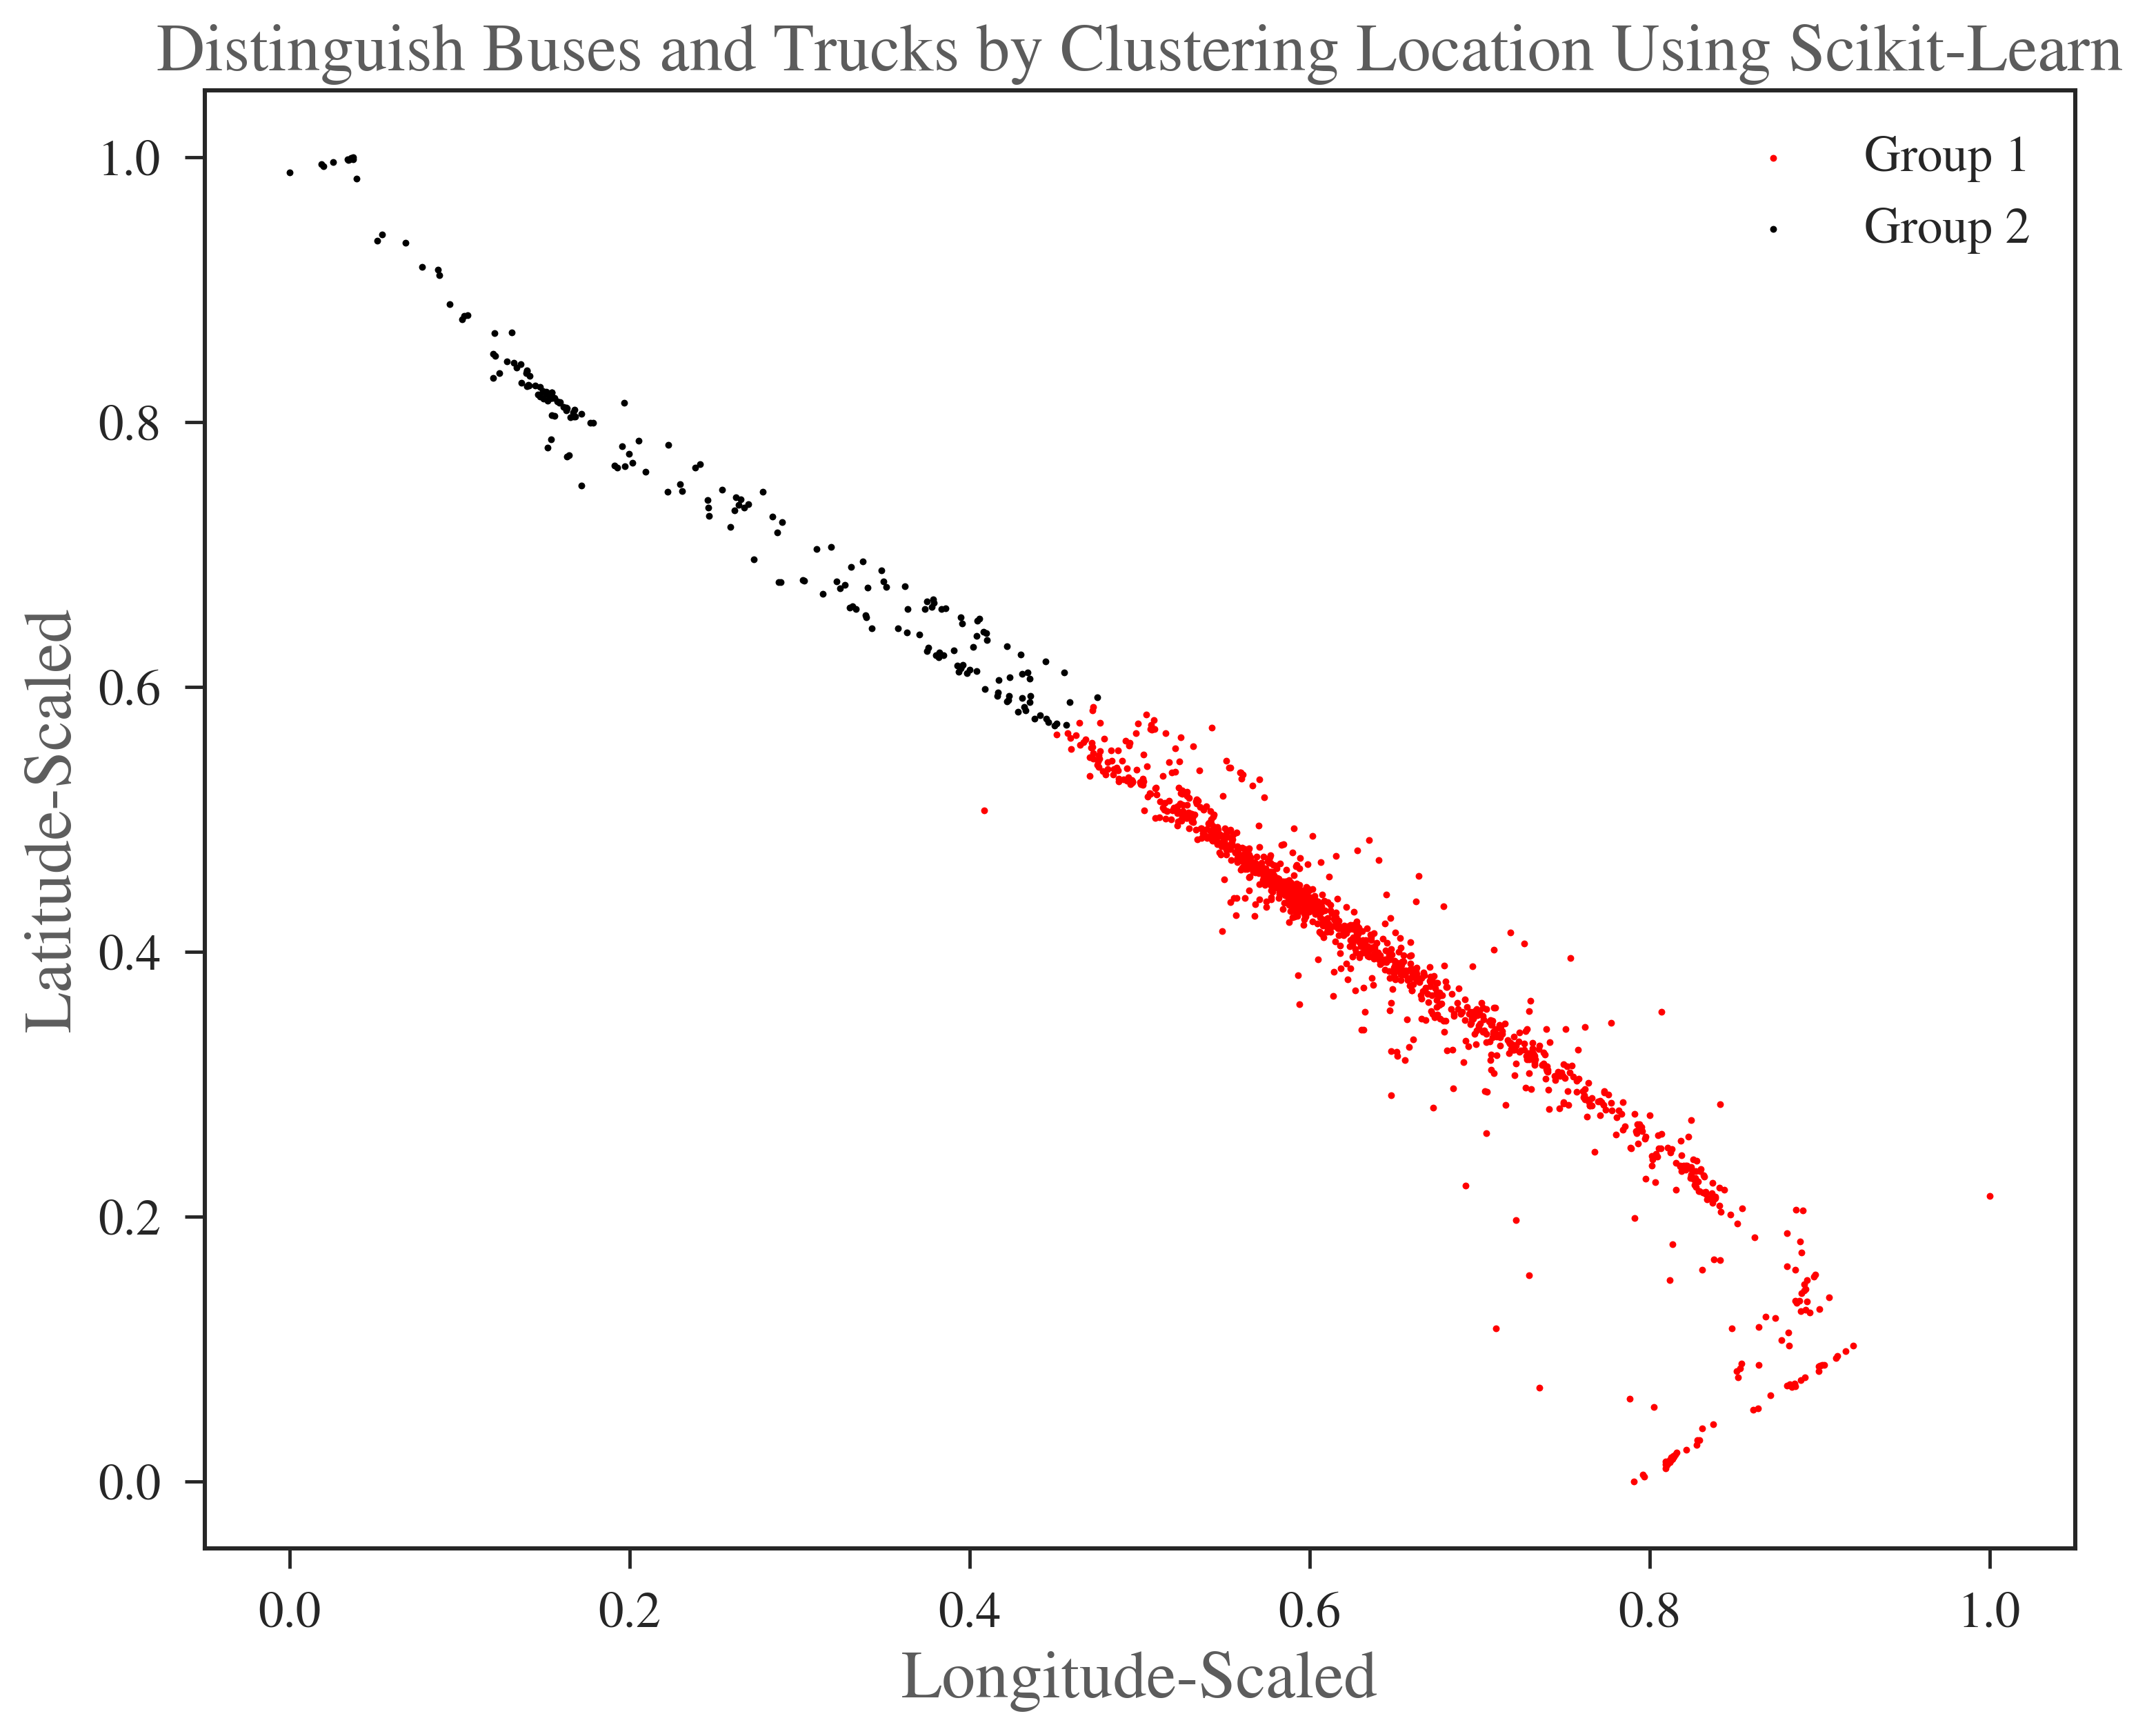

In [199]:
color_mapping = {0:'red', 1:'black'}
df_group_0 = df_mean_long_lati[df_mean_long_lati.group == 0]
df_group_1 = df_mean_long_lati[df_mean_long_lati.group == 1]

g0 = plt.scatter(df_group_0.longitude, df_group_0.latitude, s=3, color = 'red')
g1 = plt.scatter(df_group_1.longitude, df_group_1.latitude, s=3, color = 'black')

plt.title('Distinguish Buses and Trucks by Clustering Location Using Scikit-Learn', alpha=0.75, fontsize=20)   
plt.ylabel('Latitude-Scaled', alpha=0.75, fontsize=20)
plt.xlabel('Longitude-Scaled', alpha=0.75, fontsize=20)

plt.legend((g0, g1),
           ('Group 1', 'Group 2'),
           loc='upper right',
           fontsize = 15)


From the figure above we can see group 2 with black color is on the right of group, so we can say that all vehicles belongs to group 2 are buses, others are trucks.

## Try to Distinguish Vehicles into Different Days

It is hard to say the locaions information is related to the day when the vehicles traval, because there should be no difference when they pass this road on different day.
So here we'll not try to cluster them by location, but we will try to distinguish them by speed (both absolute speed and its moving angle).

In [200]:
df_machine_data_weekday.head(1)

id     event_timestamp  course_over_ground machine_id  \
0  14664310488 2015-11-16 08:22:18                 153      21564   

  vehicle_weight_type  speed_gps_kph    latitude   longitude what_day  period  \
0               HEAVY             77  -36.776549  174.745603   Monday       8   

  direction  
0     South

First we divides the data into groups according to both 'machine_id' and 'what_day', then we got the mean speed of each vehicle in one specific day.

In [201]:
group_id_day = df_machine_data.groupby(["machine_id",'what_day'])

series_speed_id_day = group_id_day['speed_gps_kph'].mean()
series_angle_id_day = group_id_day['course_over_ground'].mean()
df_mean_speed_angle = pd.DataFrame(dict(speed = series_speed_id_day, angle = series_angle_id_day)).reset_index()
df_mean_speed_angle.head(5)

machine_id   what_day       angle      speed
0      10051     Sunday  164.244444  19.144444
1      10188  Wednesday  211.321739  81.965217
2      10303     Sunday  210.404959  73.355372
3      10303   Thursday  210.719298  79.552632
4      10382     Monday   53.666667   7.666667

Then we calculate the mean speed of each day, one vehicle only contributes once on a specific day.

The mean speed of vehicle seems not good for distinguishing the day in a week, however, we'd like to continue to show the real cluster result.

In [202]:
minmax_scale = preprocessing.MinMaxScaler().fit(df_mean_speed_angle[['speed', 'angle']])
df_mean_speed_angle[['speed', 'angle']] = minmax_scale.transform(df_mean_speed_angle[['speed', 'angle']])

# We have six weekdays to cluster                                                     
km = KMeans(n_clusters = 6, init='random')
km.fit(df_mean_speed_angle[['speed', 'angle']].values)
predictions = km.predict(df_mean_speed_angle[['speed', 'angle']].values)
df_mean_speed_angle['group'] = predictions
df_mean_speed_angle.head(5)

machine_id   what_day     angle     speed  group
0      10051     Sunday  0.487109  0.075076      5
1      10188  Wednesday  0.625883  0.321432      0
2      10303     Sunday  0.623181  0.287668      0
3      10303   Thursday  0.624108  0.311971      0
4      10382     Monday  0.161147  0.030065      2

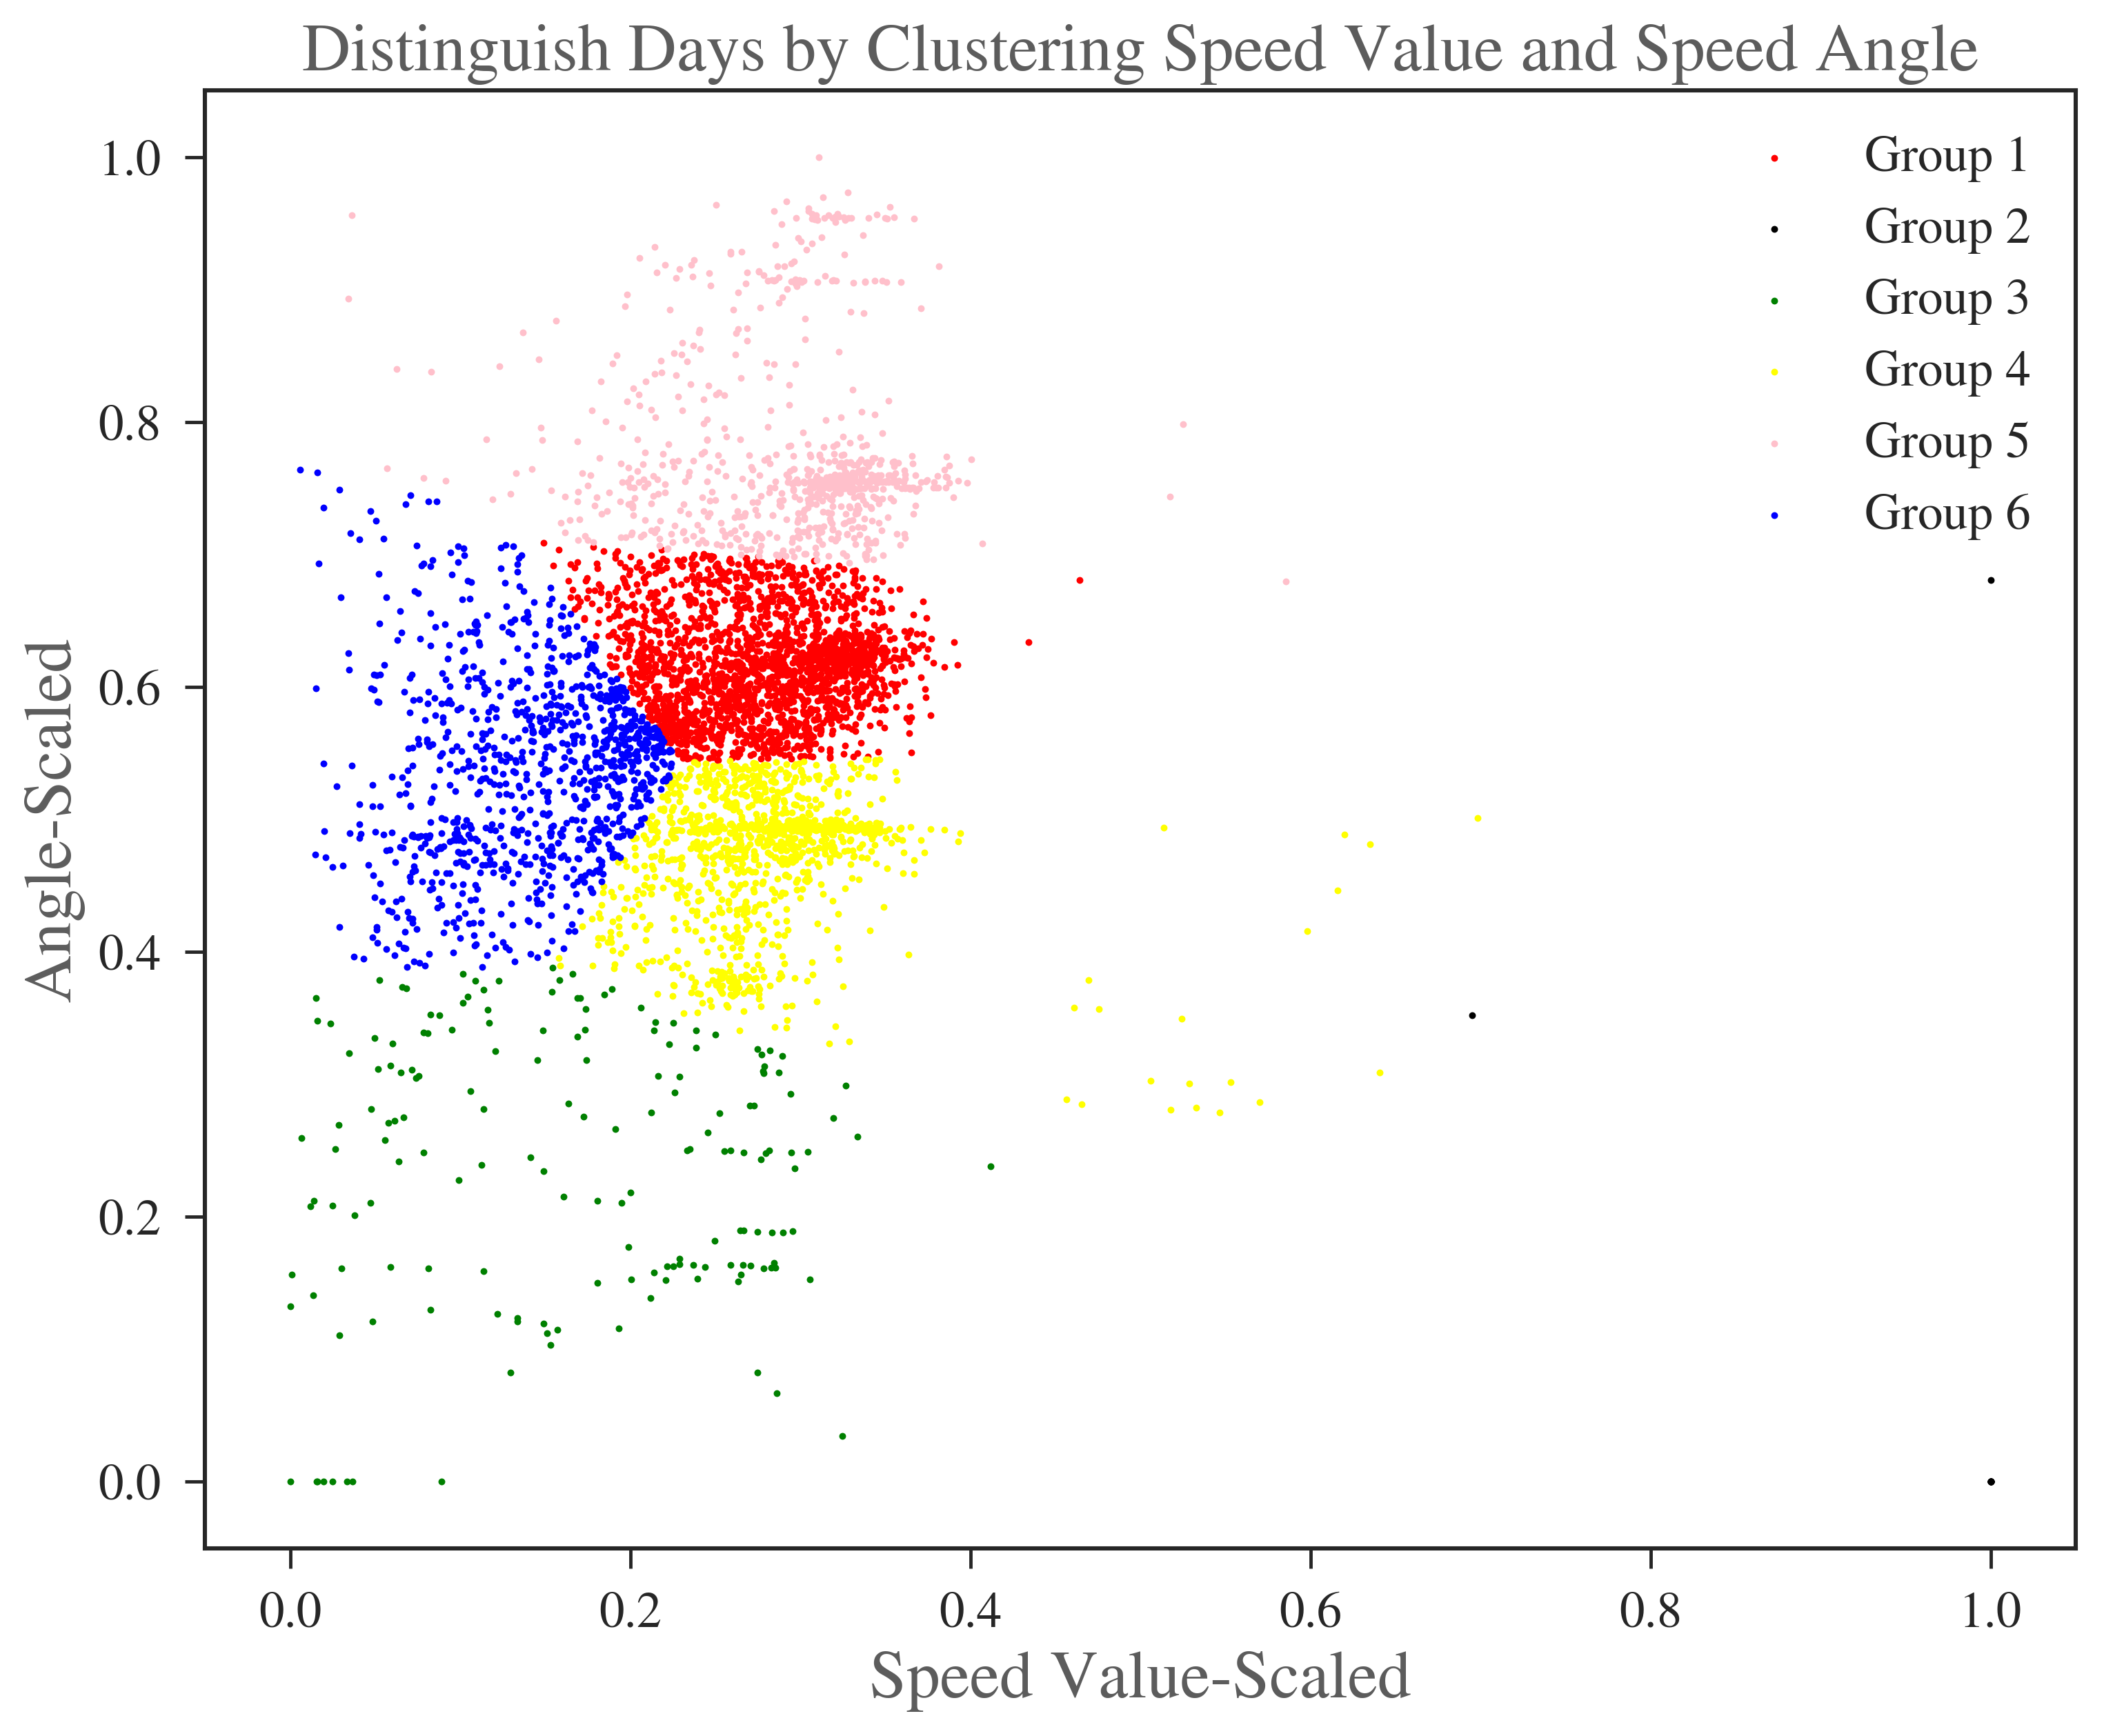

In [203]:
df_group_0 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 0]
df_group_1 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 1]
df_group_2 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 2]
df_group_3 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 3]
df_group_4 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 4]
df_group_5 = df_mean_speed_angle[['speed', 'angle']][df_mean_speed_angle.group == 5]

g0 = plt.scatter(df_group_0.speed, df_group_0.angle, s=3, color = 'red')
g1 = plt.scatter(df_group_1.speed, df_group_1.angle, s=3, color = 'black')
g2 = plt.scatter(df_group_2.speed, df_group_2.angle, s=3, color = 'green')
g3 = plt.scatter(df_group_3.speed, df_group_3.angle, s=3, color = 'yellow')
g4 = plt.scatter(df_group_4.speed, df_group_4.angle, s=3, color = 'pink')
g5 = plt.scatter(df_group_5.speed, df_group_5.angle, s=3, color = 'blue')

plt.title('Distinguish Days by Clustering Speed Value and Speed Angle', alpha=0.75, fontsize=20)   
plt.ylabel('Angle-Scaled', alpha=0.75, fontsize=20)
plt.xlabel('Speed Value-Scaled', alpha=0.75, fontsize=20)

plt.legend((g0, g1,g2,g3,g4,g5),
           ('Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6'),
           loc='upper right',
           fontsize = 15)

The figure seems OK to distinguish day by speed (absolute value and moving angle), however, we doubt that if it is robust enough, let's check the prediction with the real value.

In [204]:
df_mean_speed_angle[df_mean_speed_angle.group == 1]['what_day'].unique()

array(['Monday', 'Thursday', 'Tuesday', 'Wednesday', 'Sunday', 'Friday'], dtype=object)

We can clearly see that the vehicle data that classified to same group could be collected on any day in a week.
So at the end, it is NOT reliable to distinguish vehicles into different days according to speed and speed direction.

# Conclusion

In this notebook, we analyse GPS data and road segments data of Northern Motorway, we also build different types of models and try to find out the relationship between different aspects. 

Linear model, KNN model, Polynomial model and Naive Bayes model are used in this notebook, we also build two cluster models for further investigation.

We found that Wednesday is the busiest day in a week. During 19:00 to 21:00 the traffic is busier on weekday. The speed and direction has no strong relationship. Driving to north usually means a faster speed. We can predict direction based on our model but can not predict week day based on speed and direction.